### Basic Imports

In [220]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [221]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 10

approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": [] }

w_vector = np.asarray([4,3,2,1])

### Simulator Backend

In [222]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [223]:
from scipy.optimize import minimize

### K input states (computational basis)

In [224]:
from utiles import *

In [225]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [226]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [227]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 8
}

In [228]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 8
     }

In [229]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [230]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [231]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [232]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [233]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [234]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [235]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [236]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [237]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [238]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    L_w = 0
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_string(LiH_molecule_4_qubits)
    
    for j in tqdm(range(K)):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        approximated_energy = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        insert_approximated_energy_to_list_of_all_approximated_energies(
            approximated_energies_dict["approximated_eneriges_"+str(j)], approximated_energy)
        L_w += w_vector[j]*approximated_energy
        
    return L_w

### Optimization

In [239]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=12)
    optimizer_result = minimize(cost_function,x0=initial_thetas,args=(hamiltonian),method="BFGS",options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [240]:
def get_approximated_k_eigenvalues_of_hamiltonian(hamiltonian):
    approximated_k_eigenvalues = []
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    for eigenvalue_index, eigenvector in enumerate(computational_eigenvectors):
        optimal_ansatz_state = get_ansatz_state(optimal_thetas, eigenvector)
        approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)
        approximated_k_eigenvalues.append(approximated_eigenvalue)

    return approximated_k_eigenvalues

## Comparsion

In [241]:
from numpy import linalg as LA
from statistics import mean

def get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues):
    approximated_errors = []
    for exact_eigenvalue, approximated_eigenvalue in zip(exact_k_eigenvalues, approximated_k_eigenvalues):
        approximated_errors.append(abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue))
        
    return mean(approximated_errors)

In [242]:
def get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, k):
    eigenvalues = LA.eig(hamiltonian.to_matrix())[0]
    
    return sorted(eigenvalues,reverse=True)[:k]

In [243]:
def compare_exact_and_approximated_eigenvectors(hamiltonian, approximated_k_eigenvalues):
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print("Exact K Eigenvalues:")
    print(exact_k_eigenvalues)
    
    print("\nApproximated K Eigenvalues:")
    print(approximated_k_eigenvalues)

    print("\nMean Approximation error:")
    print(get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues))

## Visualization

In [244]:
def insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energies_list, energy):
    approximated_energies_list.append(energy)

In [27]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0,margin)
    plt.plot(approximated_energies["approximated_eneriges_0"])
    plt.plot(approximated_energies["approximated_eneriges_1"])
    plt.plot(approximated_energies["approximated_eneriges_2"])
    plt.plot(approximated_energies["approximated_eneriges_3"])
    
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [4]:
from qiskit.opflow import X, Z, Y, I, H, S

In [5]:
LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
-0.0029329964409502266*(X^X^Y^Y) + \
0.0029329964409502266*(X^Y^Y^X) + \
0.01291078027311749*(X^Z^X^I) + \
-0.0013743761078958677*(X^Z^X^Z) + \
0.011536413200774975*(X^I^X^I) + \
0.0029329964409502266*(Y^X^X^Y) + \
-0.0029329964409502266*(Y^Y^X^X) + \
0.01291078027311749*(Y^Z^Y^I) + \
-0.0013743761078958677*(Y^Z^Y^Z) + \
0.011536413200774975*(Y^I^Y^I) + \
0.16199475388004184*(Z^I^I^I) + \
0.011536413200774975*(Z^X^Z^X) + \
0.011536413200774975*(Z^Y^Z^Y) + \
0.12444770133137588*(Z^Z^I^I) + \
0.054130445793298836*(Z^I^Z^I) + \
0.05706344223424907*(Z^I^I^Z) + \
0.012910780273117487*(I^X^Z^X) + \
-0.0013743761078958677*(I^X^I^X) + \
0.012910780273117487*(I^Y^Z^Y) + \
-0.0013743761078958677*(I^Y^I^Y) + \
0.16199475388004186*(I^Z^I^I) + \
0.05706344223424907*(I^Z^Z^I) + \
0.054130445793298836*(I^Z^I^Z) + \
-0.013243698330265966*(I^I^Z^I) + \
0.08479609543670981*(I^I^Z^Z) + \
-0.013243698330265952*(I^I^I^Z)

In [246]:
%%time
LiH_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(LiH_molecule_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.93s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.89s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.00s/it]


CPU times: total: 1h 28min 55s
Wall time: 1h 29min 51s


In [247]:
compare_exact_and_approximated_eigenvectors(LiH_molecule_4_qubits, LiH_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j)]

Approximated K Eigenvalues:
[-7.620334218913603, -7.54610441440547, -7.486411159747651, -7.437668908979467]

Mean Approximation error:
0.06846818402803148


In [248]:
print(approximated_energies_dict)
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": [] }

{'approximated_eneriges_0': [-7.618997550637628, -7.610480926269329, -7.6173332886703315, -7.623505214696187, -7.610088338419853, -7.64478562914718, -7.622021571189597, -7.635477670881315, -7.626098520564665, -7.6271981294186775, -7.617633040410839, -7.615425457017947, -7.614435279234702, -7.596667679951785, -7.593371300726658, -7.609843631611862, -7.615520725001219, -7.600940447144158, -7.607593895124169, -7.608238596363764, -7.60407574929114, -7.611476224243539, -7.604786636578374, -7.61697364182984, -7.597380602767152, -7.618088655709216, -7.648136966842622, -7.637478153696063, -7.632750645774993, -7.620861256592474, -7.631521932163403, -7.623061948219196, -7.637408328558249, -7.626220360422885, -7.6178159319765655, -7.613673202016805, -7.6348507211365995, -7.635673278850026, -7.632269061959291, -7.624022078477773, -7.619296048022718, -7.617992397361088, -7.619112034492853, -7.611294753339254, -7.613126318591904, -7.627987001500941, -7.615553597688461, -7.617758051324575, -7.6407259

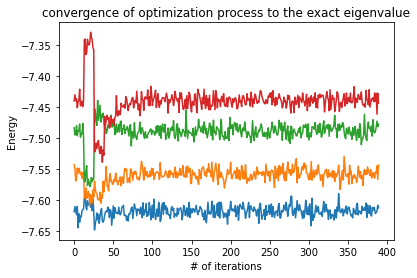

In [18]:
LiH_approximated_energies = {'approximated_eneriges_0': [-7.618997550637628, -7.610480926269329, -7.6173332886703315, -7.623505214696187, -7.610088338419853, -7.64478562914718, -7.622021571189597, -7.635477670881315, -7.626098520564665, -7.6271981294186775, -7.617633040410839, -7.615425457017947, -7.614435279234702, -7.596667679951785, -7.593371300726658, -7.609843631611862, -7.615520725001219, -7.600940447144158, -7.607593895124169, -7.608238596363764, -7.60407574929114, -7.611476224243539, -7.604786636578374, -7.61697364182984, -7.597380602767152, -7.618088655709216, -7.648136966842622, -7.637478153696063, -7.632750645774993, -7.620861256592474, -7.631521932163403, -7.623061948219196, -7.637408328558249, -7.626220360422885, -7.6178159319765655, -7.613673202016805, -7.6348507211365995, -7.635673278850026, -7.632269061959291, -7.624022078477773, -7.619296048022718, -7.617992397361088, -7.619112034492853, -7.611294753339254, -7.613126318591904, -7.627987001500941, -7.615553597688461, -7.617758051324575, -7.6407259838847414, -7.62554915914682, -7.609406356604141, -7.629280257575774, -7.612316003143458, -7.618275823449003, -7.621372316310831, -7.621352134874688, -7.622017638781947, -7.611447127837583, -7.62142709191924, -7.623835434933174, -7.6202967630078335, -7.611695866345221, -7.610048227212438, -7.608504754081798, -7.624988298948814, -7.624574323834143, -7.624212600097442, -7.632722228033014, -7.626042233194083, -7.633860534700012, -7.622135073488501, -7.622910576392271, -7.618732262333909, -7.613035085179579, -7.611239089291161, -7.6298915085193055, -7.618157878101263, -7.6064135068388135, -7.612852969841108, -7.614263030077377, -7.625266585978547, -7.614338470531903, -7.616436761200159, -7.614899599672566, -7.622576299661742, -7.611345339353559, -7.6162814644781145, -7.6284038222878365, -7.604417962279712, -7.624314193259717, -7.616288834757081, -7.6194710868628714, -7.605906462141927, -7.626388717316055, -7.619425435361605, -7.624292917614026, -7.603773605091436, -7.613044324343118, -7.631861718456257, -7.617075390978326, -7.608384326022172, -7.628289724432083, -7.598536384533995, -7.621054859047776, -7.631132238246868, -7.623791675086147, -7.614530249768035, -7.626306987302526, -7.60352792470608, -7.610154030651772, -7.634598043847693, -7.631281503818557, -7.609793552769587, -7.605009684545925, -7.623061339905812, -7.603884147357137, -7.6144036835346025, -7.609114799437172, -7.622492537337337, -7.612836972844502, -7.622404758470853, -7.624272174067093, -7.6239555657757, -7.62995974847596, -7.614143915583, -7.610602826351419, -7.6168003967620015, -7.61319996835665, -7.6277222287366415, -7.622193672123307, -7.622714973666225, -7.626075655148806, -7.61294539081423, -7.622860997996276, -7.614999616341463, -7.613690534837922, -7.6124468942057915, -7.616441975560708, -7.631832886498234, -7.622781108707719, -7.608679132706951, -7.612308007221818, -7.624865509449079, -7.621865030483191, -7.6124910268200825, -7.626652301680151, -7.623181394701262, -7.603679531380131, -7.628022855866006, -7.613935565006857, -7.620861989208266, -7.619965051758071, -7.613598888165691, -7.616031014105496, -7.619463598173939, -7.613933917669566, -7.608431649761187, -7.617950488983106, -7.623484004891313, -7.617413875980817, -7.618266779266686, -7.610435740375599, -7.613319865754844, -7.614849343172903, -7.62625049411666, -7.621285683307869, -7.631944581791012, -7.616818618654006, -7.628691448189599, -7.6365685751459855, -7.621099313808027, -7.603221746932189, -7.62193272345851, -7.618949886847149, -7.622925525380597, -7.621285517282804, -7.601887601143966, -7.611510109606872, -7.627810965394961, -7.608247345702901, -7.628446095520228, -7.6234209376285635, -7.617989884816024, -7.605504986676524, -7.625678115582505, -7.603179219222223, -7.62906025637082, -7.605565272806742, -7.603676388014099, -7.61645278558117, -7.618676011619247, -7.628445936090922, -7.6212045671791575, -7.622179335549304, -7.627002330203892, -7.620835814463078, -7.638837706482865, -7.615669854080143, -7.62495282129303, -7.615513537054286, -7.60222289719427, -7.6132026438791, -7.617249379959615, -7.614305876141671, -7.616315472121802, -7.618864482951554, -7.608654272478824, -7.626754065854449, -7.618965587366839, -7.60943546453643, -7.6325061462406385, -7.616498823164686, -7.606917925736899, -7.6100093369911415, -7.611242131940075, -7.614773925885917, -7.60364925749224, -7.613762432857635, -7.615902556894497, -7.629558974761092, -7.621930054966044, -7.618107389398779, -7.611536793706171, -7.603771183511764, -7.6282041506118246, -7.609572616970213, -7.609755277438687, -7.615190237299118, -7.6162630732718455, -7.618512575455905, -7.611021542362954, -7.616008454692137, -7.616015351959357, -7.625713098313091, -7.6183741349795255, -7.614739942025746, -7.637524220923865, -7.607923657553463, -7.604992089482831, -7.619762933061927, -7.630860170211368, -7.624589577708378, -7.624009332551643, -7.614943475689609, -7.631387561389243, -7.608758581919817, -7.624652858321944, -7.618994857580634, -7.619755842236499, -7.6080396454932355, -7.623038459934276, -7.616992282138934, -7.6062602817640474, -7.626750250974984, -7.610526604423422, -7.620322472413175, -7.628239783697978, -7.620318310745914, -7.617842951491953, -7.617842377658008, -7.625151940422194, -7.608131623698308, -7.605535008185643, -7.628715241477482, -7.628945409591395, -7.6170543771072605, -7.619077338032333, -7.618510451742085, -7.607867762644357, -7.6121478195298895, -7.6167650961527835, -7.603543515035277, -7.6137578764084015, -7.626088287570026, -7.615760832326173, -7.607045105371093, -7.610365766430638, -7.593864176360707, -7.593819366294541, -7.6219697816085725, -7.624803402557068, -7.616028676581942, -7.6132827782180295, -7.628732261654719, -7.615543340062036, -7.600703830317086, -7.615499352976368, -7.617347094793952, -7.607301780672655, -7.6147410313233665, -7.61712388659196, -7.623151084042538, -7.629847404553394, -7.617314073196068, -7.628508814927037, -7.616084306624279, -7.600391185094371, -7.619783437925449, -7.623207607484169, -7.610712946784923, -7.6237048219113435, -7.606159139600775, -7.625663726150075, -7.641628368826811, -7.596874012188772, -7.632819221015846, -7.623990335106132, -7.628126951692955, -7.61789331481666, -7.608518944079376, -7.619394894709494, -7.611810807054209, -7.610695139592668, -7.622245839765307, -7.62228820156956, -7.622802988810058, -7.61918891749788, -7.626205179089884, -7.612568075861343, -7.6021409716587405, -7.6193721043258344, -7.612031511106459, -7.606701449946666, -7.618516592605929, -7.615496104383451, -7.631233849908261, -7.6176321243038165, -7.616041737919342, -7.629836804168784, -7.623806246969474, -7.623153813187744, -7.6262041342584785, -7.63222571761923, -7.615927572929391, -7.615637843113168, -7.628989379477164, -7.611249809275873, -7.618138445331134, -7.589796715639192, -7.610252689231846, -7.619855867670384, -7.620154027882412, -7.615011050427366, -7.614128631724307, -7.625515213236831, -7.616423379693466, -7.619800391656211, -7.611674616475877, -7.609549239179323, -7.622517518919752, -7.614550152764927, -7.611139846182755, -7.615031643036884, -7.620822778839895, -7.625542661430702, -7.624106688064849, -7.62874960469449, -7.613421494568084, -7.620892006359266, -7.617074957790849, -7.623184760072127, -7.607617928314698, -7.605073330263867, -7.624018721203671, -7.617403285626647, -7.6200565447298185, -7.618303954988801, -7.622529803202882, -7.610233570601612, -7.616529032766735, -7.6165539834534695, -7.61205983743602, -7.616384528690796, -7.604608435671308, -7.628091908864926, -7.607841680849027, -7.616300230862924, -7.621390696408211, -7.609138262845184, -7.62263853373434, -7.625731853406353, -7.611979088608701, -7.616549158713561, -7.611665819216346, -7.614700084450967, -7.621695644772849, -7.620038437164528, -7.618388435779515, -7.608160058638319, -7.6126981765104365], 'approximated_eneriges_1': [-7.542781394062959, -7.550185582468215, -7.569363134110398, -7.563807296372032, -7.548565596849802, -7.5565825150451165, -7.548571092215402, -7.552438316106664, -7.558951111070247, -7.55545619779401, -7.565807509727073, -7.556182324777833, -7.554704524959184, -7.5971937079604785, -7.594641223278835, -7.580284012059944, -7.597154854133504, -7.596173211769684, -7.585910522624215, -7.590471471773909, -7.609213013281404, -7.591018165243176, -7.594532013481479, -7.604777358506599, -7.5836065003540645, -7.595045175397471, -7.5691775915147, -7.582097186798132, -7.588780010987919, -7.589407091571218, -7.5986226305094915, -7.5992424466468345, -7.600161336746129, -7.587367087343173, -7.604951803379973, -7.592830659891467, -7.597061674817231, -7.569784461110343, -7.586934918916424, -7.571359674838494, -7.567180195441183, -7.545836221206495, -7.577107079749132, -7.577111807917774, -7.585389092166244, -7.565259781631974, -7.5571173530160145, -7.57003533347449, -7.569384397703425, -7.5749259838781535, -7.572466286304735, -7.566525904897209, -7.570283201736822, -7.556418512000197, -7.562065067259082, -7.571449057286902, -7.575332797548742, -7.568753616516884, -7.568863135980688, -7.562551742599056, -7.577192497360194, -7.5656383243123235, -7.562813430219432, -7.573043270386835, -7.55393087282201, -7.548896960941694, -7.553239718997286, -7.550023018757598, -7.571566326705239, -7.568871221966073, -7.564252715119794, -7.57195505814056, -7.549626826241173, -7.551312203818162, -7.559748506216345, -7.568062155672156, -7.554764165691475, -7.558647746808194, -7.553336313584223, -7.554761759298726, -7.563723154294412, -7.566365375994354, -7.56331091235108, -7.567695415478053, -7.562914536221659, -7.552077223672526, -7.5376233858371124, -7.54395823466146, -7.554757749578433, -7.567850003021715, -7.5471627601705125, -7.556713118589958, -7.560825838937916, -7.554128771430694, -7.563441205711141, -7.559431900581939, -7.562096874903658, -7.5532106506217565, -7.561711455920944, -7.548873016273169, -7.5594048607368265, -7.549594069593744, -7.566707607558565, -7.562276916780756, -7.556027532610463, -7.555641582678695, -7.554022949740425, -7.555948330869396, -7.556650597340397, -7.56675162274143, -7.5395706627607435, -7.559038801445128, -7.562948736374391, -7.561647419013891, -7.562445221841472, -7.56120451015629, -7.557702754030458, -7.552697559337445, -7.5568281558311305, -7.560857111913746, -7.564036217096545, -7.552797779049, -7.5632820431358425, -7.552527335661449, -7.5582284593451465, -7.556092968634201, -7.558997306018873, -7.563480605772747, -7.554325311690083, -7.547122306197743, -7.564181511155444, -7.554400888600787, -7.564015704128637, -7.557305640650217, -7.559619590537352, -7.548814387834718, -7.556121454201294, -7.560287968722029, -7.553180264793033, -7.54450200730506, -7.561928090299141, -7.559068753311379, -7.563319679309885, -7.546452912871493, -7.562988358536883, -7.5449927876820935, -7.555139380948478, -7.552439538446163, -7.5485908451765305, -7.573580661911988, -7.572356302170382, -7.55179846885015, -7.558211943710354, -7.559394323496649, -7.55616165340403, -7.563223089656228, -7.565978719380313, -7.561312722016431, -7.568429029494956, -7.57449382731796, -7.550844807429, -7.561698482573642, -7.565587106432359, -7.549430533417859, -7.5481822425410074, -7.546271709383609, -7.551914410183894, -7.5599741817310555, -7.555355568087466, -7.562329618246007, -7.549883828210045, -7.554623075507142, -7.541195806415717, -7.5545360612766155, -7.553561485133171, -7.562302091530177, -7.538833450349663, -7.5642059085456195, -7.570313701181086, -7.55543444561609, -7.5492908276177895, -7.540327881793862, -7.548603979152847, -7.565192272176241, -7.5748963450284155, -7.541772561468417, -7.562900876382404, -7.563325914654017, -7.554993815036292, -7.561420359282417, -7.564748304277735, -7.56714961393056, -7.580649308859295, -7.573571545728523, -7.566929573037895, -7.56074429590485, -7.550612287955246, -7.558339506018185, -7.556814815948197, -7.554006415262309, -7.539166047147878, -7.564996341742295, -7.565588642289746, -7.559572336603344, -7.556811486608315, -7.552700492002252, -7.556154673060057, -7.5652088194448925, -7.547593998065108, -7.560606381544041, -7.565546047827967, -7.551274530992588, -7.567366115588798, -7.562824272255002, -7.5441981997133265, -7.547047424324131, -7.56560083570997, -7.553345234025736, -7.565997238378504, -7.5429994124255835, -7.562945019778434, -7.572842754096034, -7.564602183969304, -7.565573463132203, -7.569428221884437, -7.560623428200781, -7.5584231869094225, -7.567822913669562, -7.565686126728, -7.5599527172424015, -7.5539315682097685, -7.56177253749521, -7.566083470688295, -7.551879498930911, -7.546757362617431, -7.559318819906073, -7.554799632911101, -7.557625277395236, -7.555694422535444, -7.556051564431137, -7.560316779331879, -7.553646186934367, -7.55865240326818, -7.556298989212497, -7.571864101464962, -7.541927011864445, -7.55100485198928, -7.559499530274485, -7.560672529549176, -7.553783228999915, -7.569474061419773, -7.5585309043545585, -7.551543995541038, -7.55353414498031, -7.553009672152937, -7.5639083963459814, -7.579962688407069, -7.54521078421266, -7.564577787837151, -7.557163652122674, -7.548317803739227, -7.568588724083699, -7.544329540061767, -7.559617578806413, -7.546446295581645, -7.551066757314408, -7.557190573948905, -7.540790964281444, -7.563379974050643, -7.568633901299229, -7.553914368929113, -7.568720765721404, -7.55237468857023, -7.5386083173953455, -7.5507730135620115, -7.5573315672225725, -7.5508985061407365, -7.56004622243319, -7.558537256138658, -7.542389538284826, -7.55577501317276, -7.554731590491322, -7.548422989500854, -7.536869206267527, -7.533107524266762, -7.572112448597069, -7.54693670589658, -7.564248428872991, -7.564197370453099, -7.5585991229321134, -7.557882848567721, -7.548002220151805, -7.545293866975889, -7.551347752356786, -7.540112500080843, -7.548055217566831, -7.543430799794689, -7.556528770197729, -7.557519699053207, -7.563083224362731, -7.5674021915915, -7.556200924107559, -7.566614913404412, -7.537728601822311, -7.568155116316754, -7.560027113728949, -7.551364479925847, -7.563181020410761, -7.556098999563847, -7.551580443869554, -7.559352253251949, -7.547728708408429, -7.54319562459606, -7.556143106430341, -7.558063740242254, -7.568287982944614, -7.560983287469222, -7.559248384235308, -7.5785663235532885, -7.559956704182689, -7.556211565129023, -7.552331192924875, -7.550240766273559, -7.5588634475409835, -7.563929147485428, -7.551386837894273, -7.562187678077973, -7.55681842673428, -7.560983794356051, -7.562205127323186, -7.552690654328584, -7.564352283585848, -7.553069285093903, -7.5702570598862735, -7.5566715556481245, -7.562659249248853, -7.559707284506982, -7.555062555303932, -7.543921779459684, -7.557660251070281, -7.582943874968428, -7.56872715871649, -7.559312900593626, -7.551981773452574, -7.567636267200324, -7.529628395224291, -7.545250808080344, -7.559834185944084, -7.561704852122661, -7.560921905676622, -7.557278817856763, -7.57429866131632, -7.544068180572754, -7.558299444065721, -7.55359623975919, -7.57350907683457, -7.561311609762304, -7.565368850391842, -7.5590385148627, -7.562256463472356, -7.563989943457417, -7.571673070017725, -7.5631280204924245, -7.545472857206962, -7.553953332847619, -7.563536000249261, -7.554176903303158, -7.565640669659465, -7.560630402272142, -7.57640885110065, -7.556538749875807, -7.550757486693854, -7.558980141498644, -7.552776397544293, -7.558600096811314, -7.546432083790486, -7.55153439804032, -7.556849954639929, -7.560170947765867, -7.55093679148528, -7.563424272691072, -7.563905127786486, -7.555603390491505, -7.556930615982211, -7.564614119921806, -7.555141589562034, -7.556574057351306, -7.54473198313774, -7.567020042354055, -7.543401730567121], 'approximated_eneriges_2': [-7.483470648107537, -7.495171486868874, -7.493593297950695, -7.480196593126849, -7.496309913736398, -7.488482414281333, -7.488468104571432, -7.4773741280423645, -7.4986021643937635, -7.49282656776535, -7.4933202303468525, -7.4763796629565995, -7.4989510931035905, -7.569665254502699, -7.570423205769665, -7.553271160359897, -7.544616511817295, -7.576686996262329, -7.566406941734005, -7.5706433387989645, -7.578364605356619, -7.5745876613641965, -7.563545335900455, -7.570309945476555, -7.564871948432687, -7.565953437340654, -7.452536097883172, -7.456918520324882, -7.474399366605977, -7.47965199539586, -7.439168561158794, -7.4712310191216815, -7.459636970113917, -7.446950874381367, -7.474254053028406, -7.4622992868814055, -7.466412486572335, -7.459792106964624, -7.474457559807668, -7.485382153649868, -7.481943387515033, -7.492739265102922, -7.489688345216967, -7.479144641702352, -7.479463624546216, -7.483063774630265, -7.4673044298407625, -7.463006340882607, -7.481865357532921, -7.481985564876633, -7.47023936319463, -7.470545212340883, -7.4946293388588225, -7.492571845935484, -7.477338639759193, -7.490533121573811, -7.4872017705017315, -7.478231330844369, -7.490395086118578, -7.473443935690918, -7.472599781323526, -7.4944004154744635, -7.485669292110039, -7.486121876278335, -7.4787675355541126, -7.492616071885816, -7.486852875919962, -7.4849253094409995, -7.481370361501416, -7.489130667163847, -7.496756167000903, -7.480677635020238, -7.478227838953404, -7.512819440415491, -7.489776198482611, -7.4904911144072415, -7.50013227795842, -7.475443645832784, -7.495256803810386, -7.4984581802880514, -7.502220881513219, -7.492132506914139, -7.489940668192454, -7.488104108869033, -7.4743172344662465, -7.493382651299419, -7.485109171506688, -7.483303435279057, -7.488794669768194, -7.496419065521368, -7.5005637624843615, -7.4897868359190785, -7.498106892055901, -7.499755188419778, -7.494385200764978, -7.491415432206639, -7.490011232856123, -7.48686300127447, -7.485177764844895, -7.494434593795377, -7.488139170439806, -7.4883037009002615, -7.4900337928649625, -7.495274277521221, -7.492886889374158, -7.48085734873938, -7.491384051950231, -7.48002425921585, -7.486152843585828, -7.496066457476984, -7.480474147012254, -7.5003086537196255, -7.482838341202753, -7.477393779181266, -7.489704347232883, -7.490268522576711, -7.47796195383624, -7.502158942049773, -7.4985537578201, -7.492667924470995, -7.483937751061697, -7.500103055753051, -7.495436224457318, -7.484238888656704, -7.487553760704035, -7.482014120095272, -7.487670900299074, -7.471747942631408, -7.497224017073698, -7.500611638566492, -7.494792638993657, -7.47954920078108, -7.4767812345479685, -7.504779555203246, -7.4840974541374, -7.488837770632027, -7.493704767557129, -7.497758543596138, -7.490892081994222, -7.4860191216531815, -7.489771333343773, -7.490239006704184, -7.497345172641464, -7.455182724575556, -7.488246288972823, -7.500546651571944, -7.4878067959020225, -7.48999672313463, -7.491949143984772, -7.491524613909811, -7.493088724414772, -7.496075092022724, -7.484369248130469, -7.506305931914132, -7.496191846886835, -7.482086608149981, -7.495231996795458, -7.488617321282245, -7.487751320178053, -7.46975445878247, -7.48260716879244, -7.482543058135653, -7.490098932640415, -7.4883251302559835, -7.480512291021759, -7.49196510362516, -7.474097336562984, -7.480816867765911, -7.493176103681507, -7.484231572197441, -7.499768837688339, -7.493069525634227, -7.48671559087382, -7.475804381175391, -7.480278737417501, -7.496085046650314, -7.480839622259938, -7.502958116925086, -7.471222111077816, -7.490830324206643, -7.490431456838495, -7.494786832246748, -7.4816909879391265, -7.484799754647595, -7.48539981598097, -7.487439573491647, -7.5024981002129865, -7.4890273703041155, -7.469642931824801, -7.494741780521337, -7.497649663781959, -7.497080148218932, -7.503164499980401, -7.489582098111582, -7.500678947016763, -7.4989194277956015, -7.50075254462289, -7.483597761857827, -7.5041866870316625, -7.466714366967261, -7.484633547648187, -7.481309275978568, -7.478491236287975, -7.4946107943032345, -7.480717925938732, -7.474902730297163, -7.47665754952922, -7.487164213549938, -7.476783600342875, -7.4897509888134195, -7.489941080404572, -7.481597593062721, -7.4784405856105405, -7.491747108661065, -7.497969804712073, -7.4857544664109295, -7.483842452213713, -7.4882717627598385, -7.474110804786925, -7.486195159757419, -7.491901610887231, -7.499163634705469, -7.489724209238706, -7.4907028144503585, -7.49611764195181, -7.497585833291843, -7.5073703941270615, -7.495146736024225, -7.47181134520011, -7.49490795093216, -7.504030041529581, -7.491011250894286, -7.48198131634699, -7.497903719160839, -7.498552898279163, -7.491832566076605, -7.4868716802014745, -7.488627621590239, -7.482584311490619, -7.477064493053623, -7.483000159180006, -7.496144692756203, -7.49717207485347, -7.490711509463729, -7.497677661893611, -7.491555638056072, -7.491083231841545, -7.501576603594348, -7.48353511762984, -7.49512707619787, -7.499664682671657, -7.490174510377405, -7.485720327659285, -7.474223899578154, -7.481759998931052, -7.492066342658193, -7.4878322115581915, -7.48045445033534, -7.488537686851549, -7.494360772953176, -7.495484080418776, -7.487087081134446, -7.47144354027962, -7.480426274660198, -7.48707352623901, -7.475501751654995, -7.503557682220284, -7.481164837904526, -7.48738108952984, -7.474460532318064, -7.492029370987888, -7.502133323416103, -7.486979443231592, -7.480406301876243, -7.504779227389228, -7.490106970121117, -7.508703246207063, -7.481099178642897, -7.4814293941228405, -7.501444592577277, -7.489928858850339, -7.4854159935272735, -7.489933733515383, -7.4927167242356445, -7.496752506972863, -7.495632336860028, -7.490374214047993, -7.4850323459951165, -7.491042448200448, -7.482134464591672, -7.499561050052385, -7.493639927046353, -7.491928031057352, -7.479050819899781, -7.481241377308828, -7.482990462491627, -7.477572648087406, -7.483113463325266, -7.498285240065259, -7.477259109112382, -7.5031519777182645, -7.497341462788163, -7.4912828284858, -7.498216306296473, -7.4817871910336855, -7.4822245454914995, -7.482484581216536, -7.485819201933229, -7.475022545781942, -7.488010338455335, -7.494080908530625, -7.489582752978495, -7.478909748041586, -7.49140168196574, -7.476518265139077, -7.48657506031417, -7.498548276605328, -7.4947396613383015, -7.480770016578423, -7.472241887055065, -7.492480065148122, -7.486008128767929, -7.48064812665706, -7.478924022051025, -7.485305341041679, -7.478009491888514, -7.497275886205923, -7.479164514217249, -7.483524157044127, -7.489355357388802, -7.486665494542891, -7.4840297541959515, -7.478049488591095, -7.46331043591741, -7.484224230963248, -7.485003264935668, -7.499496147545151, -7.478258074555021, -7.487998934953339, -7.477158402081188, -7.487171199480401, -7.479947854816821, -7.482316808957694, -7.474903416004364, -7.477136187385817, -7.4897770160780555, -7.497795987623953, -7.501235806343471, -7.484230157263373, -7.487154839986386, -7.493555179486025, -7.482440629342042, -7.487196847081372, -7.494940212715595, -7.490582667345882, -7.502042864644908, -7.48333396055238, -7.495534729111554, -7.492120703405362, -7.481297858458182, -7.4961181111577995, -7.503681334523871, -7.485800936280153, -7.48742044150596, -7.499350194255913, -7.476843248572116, -7.4841465750448775, -7.510693592442627, -7.501724664765044, -7.500770420801274, -7.4940457784161145, -7.461482359943236, -7.493603839348719, -7.499917198346898, -7.504082032504587, -7.481087351953455, -7.474294412718876, -7.484306183405972, -7.484313006015259, -7.489322474051254, -7.480473280393474, -7.496841014094528, -7.470457246365198, -7.489077850378021, -7.491579594099248, -7.489445314803708, -7.482302809875616, -7.472683900265166, -7.481628647948231, -7.47740269915828], 'approximated_eneriges_3': [-7.44021061462433, -7.430092043748579, -7.439646693397257, -7.43687081321577, -7.45131050955175, -7.442020888479855, -7.438626831569221, -7.4212441447818795, -7.4482293356331715, -7.446102962813859, -7.440536585115487, -7.449449436159577, -7.43894506507384, -7.3418259024404176, -7.340090152348504, -7.365436515021034, -7.362280530467687, -7.34087047181498, -7.3493490425294015, -7.349986263395394, -7.346096870796316, -7.329383801275627, -7.337566919792687, -7.34101563935805, -7.354383827841685, -7.357226139411523, -7.521947014567538, -7.521912922318953, -7.508174220741061, -7.516752264064238, -7.508123020791016, -7.503809862805815, -7.519426674031691, -7.525042036978607, -7.513333450489448, -7.515147189257006, -7.538978109141703, -7.519475463470709, -7.527629057955686, -7.465087199748296, -7.479135752357498, -7.471104333608118, -7.463285511221339, -7.469879376700873, -7.467303228180376, -7.4838863263188955, -7.481927232460859, -7.465262908139506, -7.473026079535196, -7.4753140994620955, -7.469621656797542, -7.4797597453642375, -7.466664875876938, -7.464954336129703, -7.4317041891994196, -7.461696276238309, -7.4643913000968665, -7.455909606019615, -7.4603654951947265, -7.462317667476117, -7.44370593359974, -7.448187262627214, -7.449489963974334, -7.449992141163257, -7.446124050386066, -7.451906841191738, -7.433193051844984, -7.436357837687575, -7.445727749611246, -7.455743468300072, -7.448468240732015, -7.444143082871447, -7.446388130948196, -7.4409641396358674, -7.435472236800336, -7.434490459779343, -7.451318503781922, -7.441682961626161, -7.4393490722040125, -7.44370886386841, -7.424440621815741, -7.443349643778936, -7.454509953225312, -7.444946365613834, -7.463918231536296, -7.453389155357087, -7.425164874750404, -7.436930910997695, -7.438782742949034, -7.455411817588943, -7.434807617622494, -7.433558749506889, -7.436602401379143, -7.436888805189947, -7.422449395019142, -7.447459790288173, -7.433273097877207, -7.447867763170448, -7.416580282445732, -7.4284915157037865, -7.447573202249638, -7.439290022615489, -7.4353684457048805, -7.430119643386838, -7.4227108030934, -7.450943281348199, -7.4388443767247265, -7.428541970414972, -7.446809062994671, -7.450603689121989, -7.439531172267144, -7.444969462619585, -7.437054567816054, -7.434806333199598, -7.434680663444631, -7.43606187088965, -7.441401421160422, -7.433641221803608, -7.427631137223823, -7.433956220301814, -7.459794201266685, -7.438116589986195, -7.443121017337279, -7.439315357711435, -7.436839503541771, -7.430025083762103, -7.4363137472763166, -7.4475706731322715, -7.439246562621495, -7.424618324310143, -7.4338159238619745, -7.437171605989275, -7.440766287450455, -7.43648153262418, -7.458808017038129, -7.426990897263825, -7.436456470407226, -7.4272545499938065, -7.438606410199389, -7.452745101204654, -7.454001989892445, -7.4466581094231605, -7.437604276900745, -7.452940882942894, -7.431469557048737, -7.452626662600135, -7.440029314521296, -7.4261034458844355, -7.430404638462553, -7.449043199096353, -7.457942866554234, -7.440733620887476, -7.445307821919143, -7.44713988117487, -7.430137942890421, -7.4285865558505275, -7.448923687822788, -7.459232765074074, -7.421269262729578, -7.427397059244062, -7.429856547495037, -7.436753739020512, -7.44398137133472, -7.453829080700673, -7.434771760166447, -7.444410158628428, -7.421083263453702, -7.444258413012229, -7.452155717696062, -7.431378113451394, -7.447840797927194, -7.436277441257017, -7.454371346455273, -7.430964960791167, -7.454419056725961, -7.4474283197983935, -7.448560236892337, -7.444517311379502, -7.4234505627189655, -7.439778450794356, -7.454403270504857, -7.423479696804041, -7.429197967540072, -7.451451710845506, -7.437008558165996, -7.44079906112306, -7.438741150672078, -7.449307530640649, -7.435305138012002, -7.432674270297481, -7.441424219113045, -7.428425913798241, -7.445628250246094, -7.448872933034019, -7.448264030737753, -7.435213405506873, -7.44981928464427, -7.440804751227655, -7.4337584551166795, -7.4350517081503655, -7.43696378341065, -7.445040594809045, -7.450185945622357, -7.43652151056294, -7.442014215891843, -7.439136561602016, -7.434947141938923, -7.43790432875379, -7.452922875182295, -7.452089950908358, -7.44317400448992, -7.430244588639583, -7.442345507640803, -7.43980611122142, -7.4494616553153055, -7.433794908947715, -7.431460423394951, -7.43480972184476, -7.442340440671557, -7.446732069753869, -7.445373649142412, -7.428617406975401, -7.439269382323161, -7.43788039419346, -7.436381891281635, -7.4484898541337525, -7.426029760418428, -7.435710327611539, -7.449936765245714, -7.4369747193063285, -7.444022710993686, -7.429126285338544, -7.431454788445486, -7.439023112057349, -7.444113606742696, -7.440401931553218, -7.442471782796762, -7.431294192451855, -7.4233323669455835, -7.42557544627139, -7.433166686865672, -7.436905246541801, -7.441354655947375, -7.443763169214086, -7.444920230325802, -7.438199788477806, -7.442226507966558, -7.444351363113369, -7.432433998915073, -7.433830541680792, -7.427713993029753, -7.434189166053106, -7.426888811790361, -7.446272494156123, -7.423650328281108, -7.441752633530078, -7.437075492441493, -7.448226322647884, -7.434387348031297, -7.446020822400387, -7.436777324436953, -7.4356857896578985, -7.428514665321204, -7.435169974507482, -7.437725192212828, -7.441642737983185, -7.451277919604643, -7.447634019844181, -7.434046388406338, -7.441539576657839, -7.439614688849315, -7.451743983483178, -7.44607295998303, -7.430755380833804, -7.437135388917866, -7.4319595368257385, -7.448148364711913, -7.45975542331356, -7.441462840743299, -7.440282070168663, -7.441936186333027, -7.458992277914643, -7.4339955407060785, -7.444873006813454, -7.445548874224308, -7.437771499372869, -7.43101124232422, -7.450951846453112, -7.433557077980949, -7.4368068320445575, -7.4401610753103355, -7.44286994041121, -7.427395208182167, -7.43841958536075, -7.441494616892332, -7.448493086797793, -7.441054848800888, -7.429448567816754, -7.45588385818976, -7.43818502913708, -7.435032162581879, -7.448836670123829, -7.43957052598937, -7.431748449381923, -7.4406290152903685, -7.443898121044509, -7.433956198924098, -7.440541215103549, -7.427050814877169, -7.450424251081915, -7.436611704909467, -7.4515836830722915, -7.430664388830884, -7.435157203542585, -7.428856362337244, -7.43473065757563, -7.4310205402251235, -7.431653334552429, -7.430879802273961, -7.436770974188751, -7.457821289845893, -7.4429763188970295, -7.432539961707462, -7.425220348862637, -7.434895910662594, -7.438229091551488, -7.456142606881856, -7.42200765493067, -7.454325454520747, -7.442661212345716, -7.4310028973025375, -7.437329953100845, -7.435777818870235, -7.4574320562821965, -7.4494017298494875, -7.438926251708605, -7.425408732022784, -7.427824020371183, -7.4405268054911025, -7.457220571556917, -7.444793196527404, -7.44244352365126, -7.450836558332758, -7.440889941092422, -7.435262503535602, -7.428546424442673, -7.4483500744939635, -7.442762358969482, -7.427498716524754, -7.444746530714946, -7.43812246303259, -7.434600829436619, -7.442054294095461, -7.427483285409993, -7.442901059188005, -7.443231691656296, -7.441022095139479, -7.430096768940754, -7.417214030082789, -7.451131448243966, -7.435582560858279, -7.439776342976178, -7.442589844881724, -7.429778138592427, -7.432409173987188, -7.437650841926927, -7.437642635291481, -7.425660739296005, -7.441344143028219, -7.446492214255642, -7.448011061733825, -7.445561134989027, -7.450202265952514, -7.423284301997547, -7.438080285598059, -7.438725090230772, -7.446524579960826, -7.422013285927049, -7.450230024289272, -7.443096626851941, -7.43675887500334, -7.438202489785732, -7.434851769310853, -7.441497219878412, -7.427235545058234, -7.440900838294742, -7.428167553019936, -7.461479924496093, -7.4275934320401475, -7.443777599716301]}
plot_convergence_of_optimization_process(LiH_approximated_energies)

## H2 Molecule 4 qubits

In [249]:
%%time
H2_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.00s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.95s/it]


CPU times: total: 54min 6s
Wall time: 54min 31s


In [250]:
compare_exact_and_approximated_eigenvectors(H2_molecule_Hamiltonian_4_qubits, H2_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j)]

Approximated K Eigenvalues:
[-1.1129028032262829, -1.2843215824346217, -0.9070345133228698, -0.8835839516616046]

Mean Approximation error:
1652591485736130.0


In [251]:
print(approximated_energies_dict)
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": [] }

{'approximated_eneriges_0': [-7.684872016622813, -7.682674978622313, -7.688815045540018, -7.6865610070419885, -7.699764104952971, -7.683004522411683, -7.682182188775505, -7.6717369732692955, -7.692125194859612, -7.680169373542193, -7.6869262150081745, -7.683356540904024, -7.682711822500686, -7.672241543531918, -7.678109785918325, -7.674325745371277, -7.668429619630532, -7.663553759161611, -7.68778783075317, -7.68418286503949, -7.661996814177374, -7.668160670004843, -7.6616865622406936, -7.693219164537062, -7.686701530093904, -7.674359854212713, -7.744467843890669, -7.726744407323562, -7.74519766625444, -7.725407627703116, -7.742011824285679, -7.745011538786694, -7.748204435144161, -7.735741646569016, -7.731038912428485, -7.740322298346586, -7.751222703439206, -7.719490955831602, -7.742081876115709, -7.715101150037035, -7.724964388769998, -7.722782574876512, -7.704527442053856, -7.704680245249642, -7.705938869138346, -7.739088341237903, -7.711882080489956, -7.720023572479591, -7.7140355

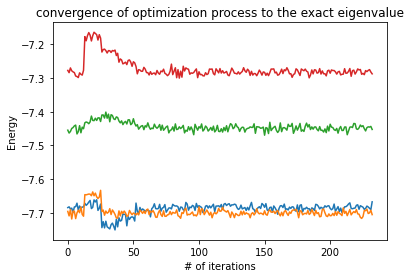

In [19]:
H2_approximated_energies = {'approximated_eneriges_0': [-7.684872016622813, -7.682674978622313, -7.688815045540018, -7.6865610070419885, -7.699764104952971, -7.683004522411683, -7.682182188775505, -7.6717369732692955, -7.692125194859612, -7.680169373542193, -7.6869262150081745, -7.683356540904024, -7.682711822500686, -7.672241543531918, -7.678109785918325, -7.674325745371277, -7.668429619630532, -7.663553759161611, -7.68778783075317, -7.68418286503949, -7.661996814177374, -7.668160670004843, -7.6616865622406936, -7.693219164537062, -7.686701530093904, -7.674359854212713, -7.744467843890669, -7.726744407323562, -7.74519766625444, -7.725407627703116, -7.742011824285679, -7.745011538786694, -7.748204435144161, -7.735741646569016, -7.731038912428485, -7.740322298346586, -7.751222703439206, -7.719490955831602, -7.742081876115709, -7.715101150037035, -7.724964388769998, -7.722782574876512, -7.704527442053856, -7.704680245249642, -7.705938869138346, -7.739088341237903, -7.711882080489956, -7.720023572479591, -7.714035525649267, -7.712254344047967, -7.714258447799942, -7.724829170590504, -7.671472596443126, -7.695858458491221, -7.703639220211599, -7.684347607809418, -7.694304291220608, -7.688915279236999, -7.691664329699855, -7.696469494117979, -7.693208722446549, -7.6927689346269466, -7.6944760644420995, -7.712394147601632, -7.688259813753724, -7.6838718380944, -7.673579722683228, -7.687873475409857, -7.688661455044823, -7.687785390016328, -7.675269408135784, -7.695557648229477, -7.686540440198848, -7.68435076403135, -7.675978521035275, -7.698554320988606, -7.692591952621479, -7.686171157823877, -7.685710738932022, -7.688852314523279, -7.675119127551612, -7.678809755911412, -7.680296085471316, -7.679802275560215, -7.682528851031586, -7.695714541032727, -7.683343799764772, -7.684022702755224, -7.6912816062380145, -7.693411101311144, -7.66951445143977, -7.674356145598618, -7.69262617646554, -7.683204193528599, -7.6851859227306045, -7.678380513918252, -7.680795668682592, -7.693294372802715, -7.672535056592712, -7.683947297497394, -7.679228975776511, -7.6820041270603445, -7.684574334375663, -7.699807419454971, -7.69473176612281, -7.680654291066053, -7.678946976792574, -7.686397179079306, -7.679686952192435, -7.685724413491124, -7.6804861459349905, -7.674921530169952, -7.696975300940349, -7.680444477992329, -7.680212485846949, -7.679610159462225, -7.683136011839403, -7.675685311349184, -7.690516731290526, -7.674955726410774, -7.672684962441973, -7.678688518964173, -7.674973826629779, -7.673312734586229, -7.680860348917919, -7.676644121390813, -7.67689173171951, -7.674703258553489, -7.675912388516514, -7.685187574088791, -7.69020520203994, -7.6879716017279565, -7.677558746063111, -7.68883006901302, -7.686848835929537, -7.684609384290992, -7.693455982195522, -7.684250162156117, -7.691933133835128, -7.679877625724085, -7.669458502037468, -7.688018823904214, -7.690680672566779, -7.699614580809857, -7.689178871465331, -7.6854353930567205, -7.682298695115261, -7.687521909964949, -7.672613522927611, -7.6766417821408615, -7.683946794524158, -7.673129724022623, -7.692298636955512, -7.693871106574285, -7.684628300001469, -7.683510945196566, -7.698420715632525, -7.680036360172531, -7.685551210144621, -7.692801087819281, -7.704721818514714, -7.687624848072401, -7.679553907071856, -7.679090513388788, -7.684661100994242, -7.6744801197057475, -7.690319439099812, -7.688414470123152, -7.69199462805962, -7.683478332179021, -7.687230534071361, -7.682429326023512, -7.683267878331939, -7.692994116092733, -7.695466191109106, -7.676930478984522, -7.697247879773602, -7.678019043281905, -7.676411785091, -7.697640099591599, -7.687375515631476, -7.688703619674149, -7.683914650293505, -7.688645487556303, -7.688114442681031, -7.6958084527099615, -7.6857563386245165, -7.6879494159275925, -7.6932274696097815, -7.675171520587664, -7.676428133895082, -7.681173127389419, -7.688882177963971, -7.683896846197974, -7.686654752086713, -7.686360843501031, -7.679493107144511, -7.683266754201486, -7.680125536650088, -7.679335522965291, -7.687329038849142, -7.6912850951700475, -7.688067908645157, -7.674372106361412, -7.696097472729249, -7.688998380944093, -7.682027215556467, -7.6967442302628575, -7.686456016216985, -7.699606574134355, -7.690031608667034, -7.682643778017314, -7.682103714489419, -7.679203444246614, -7.674171358205149, -7.670798616031632, -7.687293992016376, -7.688404970710736, -7.686879668133579, -7.686263413766541, -7.678040363219195, -7.676556709588377, -7.689800923799074, -7.679266460380688, -7.681505745661219, -7.683633168544894, -7.690155538908794, -7.687379928761206, -7.680420698845475, -7.683058292961253, -7.687146896525409, -7.690831875465735, -7.667767202091985], 'approximated_eneriges_1': [-7.69617329989715, -7.709592499645299, -7.690243778481427, -7.718783522752947, -7.695312556066702, -7.695802931358654, -7.71756567343195, -7.700447809608575, -7.69275619323503, -7.700014290351292, -7.682880798620365, -7.705174274748448, -7.710493831771609, -7.646381638828852, -7.646981237030047, -7.645688806590118, -7.644629339924422, -7.644921683214085, -7.649629870327394, -7.638275003262688, -7.649748062738595, -7.641890435269558, -7.652820692914139, -7.657952307515315, -7.6536607150501474, -7.63354973481788, -7.696922156669092, -7.692209399437145, -7.707490834018855, -7.695115251627395, -7.701599281853319, -7.698462103784512, -7.688035949647982, -7.705474077574944, -7.691984580506194, -7.697851857674031, -7.7052257726234625, -7.715690343932758, -7.716339256688663, -7.694702744402371, -7.709808564480777, -7.695932556573497, -7.702204657396482, -7.695149667215483, -7.700694350757921, -7.710778344987134, -7.708901966982428, -7.693370067522715, -7.700596562983194, -7.7059689435125645, -7.701042286321579, -7.703168270268181, -7.706697004585595, -7.701146653291754, -7.706518367597239, -7.692348420717804, -7.696254370727714, -7.702013438517047, -7.695379772081814, -7.70232229840788, -7.691541609258312, -7.689266891297264, -7.705713190892486, -7.695113658831499, -7.698454741403662, -7.693863906718927, -7.701219833501607, -7.71332170804229, -7.713833313209888, -7.70026690121217, -7.6929652866635765, -7.705953756245845, -7.71111252777951, -7.694354462913017, -7.710656152637425, -7.710673934935467, -7.706449496547028, -7.70540715809591, -7.696498341248314, -7.705800664498258, -7.6989039303750975, -7.701046963766319, -7.701038530794543, -7.691675379731183, -7.7090378533094475, -7.711327337435895, -7.716655002384747, -7.69956982296396, -7.702201750524224, -7.691340321400116, -7.6864597417921, -7.70721098007379, -7.704862400027295, -7.705704033655751, -7.70195864220163, -7.698021718165593, -7.708824261397675, -7.706588223679448, -7.7099144903150005, -7.70330598031523, -7.682763124680306, -7.705785678671919, -7.68799711649681, -7.691357417147568, -7.705786037149389, -7.698644734020064, -7.691923208361124, -7.6991871449817335, -7.7072240242972025, -7.69861914281877, -7.715133337561421, -7.7029987533349, -7.699399608586304, -7.703527180203987, -7.699287697305778, -7.687165164971293, -7.696035937372101, -7.694875905052379, -7.683732691525398, -7.69301915612206, -7.695356864494933, -7.698133537997998, -7.693810857076823, -7.703126586018021, -7.714240920782916, -7.6979041463835465, -7.704215419104744, -7.714729091185199, -7.702478132693968, -7.705540518492624, -7.708559304434797, -7.707788024962735, -7.695742777210216, -7.706543337092889, -7.695678819154884, -7.7050374590355775, -7.700384197158729, -7.703226448573548, -7.703978324659057, -7.715173545726184, -7.702944935309993, -7.699979214595283, -7.706923544128918, -7.701000223759968, -7.688217866185649, -7.699756052657243, -7.703485452027024, -7.701227688746887, -7.702818008384279, -7.706056172404428, -7.694359461079545, -7.70507834285138, -7.707602959625165, -7.695913501776388, -7.691369708311434, -7.6985477444357215, -7.698320287018868, -7.695506825608125, -7.7025792698881475, -7.6965668907960625, -7.693182337263272, -7.703344971107815, -7.70942751135178, -7.698739221205191, -7.709181730335651, -7.696568577357645, -7.693597439739971, -7.702089053370012, -7.7080744274015, -7.697707071432334, -7.702081575470281, -7.693477255824749, -7.691878184719646, -7.692518999741821, -7.6898350046526005, -7.697899879248305, -7.71505052754118, -7.693990901237677, -7.695374074128392, -7.706300282764042, -7.70330434469857, -7.701787649373089, -7.703733495140766, -7.693300410368296, -7.705315377456472, -7.701790248620237, -7.6902602981472645, -7.699510967737294, -7.708511451017487, -7.693109194608505, -7.702807624995661, -7.699966701492508, -7.7121510419036285, -7.710974737419206, -7.690755207415192, -7.689142848298468, -7.700223232145643, -7.709771978089977, -7.711454503135011, -7.703648767025844, -7.709206197735033, -7.708584102548887, -7.702073473026884, -7.708543402970366, -7.696681594590769, -7.7077110562587015, -7.697009470402002, -7.701770730744919, -7.704361527780537, -7.708690688983235, -7.685781589509866, -7.701920524199183, -7.696098347017177, -7.708873440001882, -7.699459841726872, -7.690601021609272, -7.7065417382159795, -7.7009848433950525, -7.696809477567119, -7.699947991936093, -7.690769766861855, -7.7036366667425655, -7.704410056748106, -7.7137249457307, -7.7170636815362466, -7.711614330282335, -7.693754360065115, -7.694185496667443, -7.689320987754834, -7.702491018741, -7.700585105318964, -7.692776042859012, -7.705787728034146], 'approximated_eneriges_2': [-7.454739876336982, -7.463338118697043, -7.458675503579098, -7.449708272615393, -7.447092004243191, -7.442041690092626, -7.4397005442548885, -7.4660249294358465, -7.459228270423428, -7.441394101210511, -7.462544406127681, -7.445858223411827, -7.450473727938247, -7.432870234309866, -7.430456494220749, -7.4319494729800635, -7.435605033468838, -7.4301566678503885, -7.412873488081436, -7.425805644146019, -7.426514205725286, -7.41913856618487, -7.425953601985494, -7.418263777805392, -7.418242790622187, -7.429055577742988, -7.409561408325275, -7.4096235728371305, -7.418820583043957, -7.401108184418397, -7.419260200009495, -7.407163499599214, -7.429884345604049, -7.408797571198498, -7.411131551060752, -7.421217287579032, -7.42325623921252, -7.415351202783864, -7.417186311055911, -7.427456066136027, -7.433057459454044, -7.427228284020464, -7.438232556369313, -7.431758131196813, -7.428740080974846, -7.436392776465629, -7.423905757368993, -7.42410134568373, -7.438522012939114, -7.434779372579415, -7.420802922236225, -7.434593508865628, -7.442608482074369, -7.4382805899797795, -7.451713101148341, -7.446546917478314, -7.442545868693101, -7.441314581032259, -7.453303827098749, -7.441563259329315, -7.4454249850109475, -7.43303232665837, -7.444991085977385, -7.45216807024352, -7.448691759121613, -7.4502232591967505, -7.43699020952865, -7.445261817948074, -7.449157346398748, -7.445029237539329, -7.438027084380728, -7.455153688001166, -7.439979932900446, -7.455023965079775, -7.450355197169189, -7.4451379688181785, -7.442421646676555, -7.462789275970079, -7.455263409338529, -7.453675368569354, -7.444921632075953, -7.457430014315531, -7.436140124729722, -7.453009812078923, -7.451683460744013, -7.444742766099689, -7.4500020525732715, -7.446605011278161, -7.440568536057348, -7.462783555356385, -7.454952474355568, -7.457996930569993, -7.444365067414495, -7.4543503625620735, -7.445237876036237, -7.453963867069203, -7.468333633654341, -7.437396389670026, -7.446655306206529, -7.454865587127571, -7.444348946121444, -7.448730966869169, -7.436301127486509, -7.4573498981335735, -7.452573877279241, -7.442431227071246, -7.446914144075126, -7.457424093850618, -7.45289226079866, -7.446758851275941, -7.45542973788637, -7.442863468711028, -7.459912205535187, -7.4548657365742645, -7.440571076961935, -7.458273124193542, -7.459071701515107, -7.450444711864573, -7.460404572104134, -7.446775025343623, -7.456166284170311, -7.441591470099977, -7.459623922836245, -7.446206642800526, -7.435467560788987, -7.438461776916029, -7.450415833181198, -7.446778277866521, -7.43575007020192, -7.4441370385168595, -7.447556930091188, -7.458491988194773, -7.449814251502352, -7.445857713164925, -7.446755498804915, -7.460584280972472, -7.452021964065222, -7.449578537261899, -7.448668632774882, -7.445072937740866, -7.446549389198416, -7.446455618363651, -7.435846508353611, -7.464091601105793, -7.444507164814389, -7.444937138430808, -7.445866700122488, -7.44927449227289, -7.448176997397652, -7.445581090573209, -7.469704801787054, -7.447111820479593, -7.4488522847264225, -7.464822652692767, -7.431349249215708, -7.456072204132699, -7.450289747064782, -7.446265079042616, -7.44323824912412, -7.455165362366884, -7.461598446890993, -7.4558494030421345, -7.433255352787835, -7.459272836976564, -7.447948806731719, -7.447074822417642, -7.449899263454666, -7.4547854652582854, -7.437280016813387, -7.4434884797635785, -7.443282222032396, -7.434680805600709, -7.464187776903465, -7.454596343898873, -7.442144745862725, -7.454736077313618, -7.446558519622015, -7.434761356334339, -7.457856888120524, -7.454082774634832, -7.458505680711784, -7.4429543428864315, -7.4339003888457595, -7.445390559281084, -7.438183516539577, -7.452874099264543, -7.445024021311581, -7.451817884405264, -7.445327706385705, -7.445211172878458, -7.452659349155872, -7.456742656788001, -7.444192002661022, -7.455320977898672, -7.454948585555242, -7.460356328422878, -7.450974846834088, -7.462175591953663, -7.44277244279163, -7.457187468665645, -7.437159363932872, -7.445756765506267, -7.446854274058767, -7.453408275594381, -7.455481204132241, -7.449595389506148, -7.463642148900078, -7.450153705363935, -7.443852352453544, -7.455811907660369, -7.455515068289629, -7.445450828806868, -7.445290216158658, -7.468368225762728, -7.457345447371528, -7.4458013000975, -7.4450108610544, -7.44700590998469, -7.434902720815398, -7.435497895491228, -7.451005014401704, -7.452382451548679, -7.447983213570674, -7.439492261540333, -7.4442868507040325, -7.441373463597565, -7.450259853334479, -7.45700282140928, -7.447310207195874, -7.444899079018898, -7.44569731628699, -7.4435865074477015, -7.452650200914205], 'approximated_eneriges_3': [-7.277168483642813, -7.283897545407267, -7.2697852600457455, -7.278344323259018, -7.281549934563462, -7.283698688550487, -7.293788933885686, -7.295334277799094, -7.298450628832339, -7.284327951214938, -7.288756132022205, -7.291126598037573, -7.276742344064052, -7.176800262856987, -7.189135768193463, -7.174032070616089, -7.164777320855229, -7.172412804338026, -7.189667176949004, -7.174110717562561, -7.1637642436304745, -7.167212884283146, -7.170901386595579, -7.187005721669121, -7.170950478146774, -7.181164375641265, -7.222595939061134, -7.215139673607606, -7.2139450348344125, -7.218379251588125, -7.225518007407843, -7.218406168983282, -7.21868610574562, -7.2238735326166, -7.218038045640453, -7.219528722641053, -7.216774618675246, -7.23297875365704, -7.2263290966208515, -7.252798188250353, -7.243117783122929, -7.246098846510647, -7.257781094895968, -7.2556789576493514, -7.252679940999389, -7.259913648968646, -7.247490551761822, -7.246096072987294, -7.252615632147204, -7.2650733581981335, -7.251553246986587, -7.254714046441854, -7.2654320471200995, -7.2873092260518355, -7.274992640197694, -7.275986542787054, -7.279868691257085, -7.279644758897498, -7.268122358435219, -7.273358593848958, -7.283578364418005, -7.283776699720336, -7.290705507985247, -7.281009905813749, -7.288911598817039, -7.285776294975956, -7.285061974055806, -7.289987818310247, -7.27741545729153, -7.285054938062245, -7.288653806281822, -7.279054752333304, -7.281245967223262, -7.273573195930688, -7.285745933143998, -7.288352739949003, -7.292808585588266, -7.289078503840338, -7.279653868976303, -7.258495894936428, -7.289759486853743, -7.279380908802551, -7.269236144237963, -7.298931978682297, -7.274887496052075, -7.30011163909487, -7.279408317769227, -7.297285615610993, -7.264756657579293, -7.278918184554445, -7.269661610642314, -7.272549956334215, -7.273508802208697, -7.288634496894192, -7.2845430779209925, -7.285762980424338, -7.283527755527669, -7.277688190449186, -7.272746694999241, -7.298747722681106, -7.281204152252083, -7.2897335833628425, -7.289189972033362, -7.293174806890872, -7.293569661893813, -7.283949009177751, -7.2895801060016865, -7.2870588557076195, -7.273076365863061, -7.273715942063296, -7.272969206002296, -7.28666861052259, -7.290401037430411, -7.2723405625952315, -7.278051050231674, -7.284488292894536, -7.271746277115526, -7.285052167710929, -7.277972756477915, -7.285001038983553, -7.283277413990558, -7.280302915022017, -7.290705732681043, -7.293040580162399, -7.282351076067027, -7.270362566007034, -7.27677347461232, -7.285553399523672, -7.286023513011162, -7.287818298515047, -7.281383420645142, -7.288109469048377, -7.283861022649718, -7.2802411893827195, -7.2691801534361264, -7.27832689087556, -7.282829843912543, -7.273571895857269, -7.278032477023908, -7.2920900617474995, -7.279876605859095, -7.291133284390638, -7.286438721330683, -7.286698069186761, -7.293031105472525, -7.285656729956593, -7.276303782876314, -7.282475251964163, -7.2912051985869715, -7.281748090755643, -7.2829627424256325, -7.2918331923681885, -7.285408360163024, -7.292651570349242, -7.283630249087298, -7.273142046827193, -7.27324405896747, -7.2727162133822185, -7.284696310954483, -7.282290400619987, -7.2914376272156325, -7.289737805993225, -7.283001683556268, -7.273496988700891, -7.286588044321881, -7.2752310078157265, -7.278149694485002, -7.269221860995061, -7.276652818628838, -7.2873690075507005, -7.286812551531075, -7.297734740522776, -7.289241124446415, -7.287147715425061, -7.272425628484153, -7.275690886242177, -7.283944540609145, -7.292333535257508, -7.272875205507943, -7.275858487845495, -7.278162787715271, -7.273229988930842, -7.2795131281263, -7.281950077617009, -7.299304993913853, -7.2908996810754925, -7.275823698565523, -7.2874874152601805, -7.275342560700411, -7.276075591851956, -7.2853468748802035, -7.28371765548082, -7.271868941358364, -7.288027041977412, -7.278596947949885, -7.287233093457341, -7.286885046883887, -7.293390068163302, -7.2784355814450175, -7.276531847159542, -7.2855852423899945, -7.275764107643157, -7.277532615806158, -7.277476253985112, -7.281392057724374, -7.288182438768222, -7.2815414532483596, -7.279950045497194, -7.290552611401737, -7.288714528487657, -7.288334832411804, -7.272049295910789, -7.285854457666259, -7.2849945879599005, -7.279989284942375, -7.271594970519456, -7.294683957924574, -7.277989322647548, -7.276377449183724, -7.288085993075095, -7.281448737235212, -7.272758950631381, -7.2759501675864025, -7.2744244405995735, -7.288775293712214, -7.2858281522327655, -7.289893531115216, -7.277701275005492, -7.2808264231809, -7.277127566330931, -7.2747996544464435, -7.281906006434, -7.287420376412511]}
plot_convergence_of_optimization_process(H2_approximated_energies)

##  Transverse Ising Model 4 qubits

In [252]:
%%time
TI_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(transverse_ising_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.99s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.95s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.86s/it]


CPU times: total: 1h 20min 33s
Wall time: 1h 21min


In [253]:
compare_exact_and_approximated_eigenvectors(transverse_ising_4_qubits, TI_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(3.3650474360647804+0j), (3.071726889491433+0j), (1.7088632973761595+0j), (1.48288685094461+0j)]

Approximated K Eigenvalues:
[2.530115854944646, 2.547324377781065, 2.6747166610524924, 2.659707401667607]

Mean Approximation error:
0.4444103043165892


In [254]:
print(approximated_energies_dict)
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": [] }

{'approximated_eneriges_0': [-7.48610307706854, -7.486723782889051, -7.482810231578335, -7.493273576407161, -7.479828480352569, -7.502450598250617, -7.4895475489140875, -7.485024426068045, -7.494529240753221, -7.486915714782895, -7.4812406211037, -7.478072287140875, -7.486696394899587, -7.416186448755935, -7.428041212203513, -7.4275734586457425, -7.41179815275807, -7.433825802958651, -7.417792354534976, -7.4216050984979915, -7.434787792179803, -7.43567064928438, -7.4194222964554335, -7.4153862256994225, -7.417358134838512, -7.429091207884353, -7.405295351807469, -7.396285793953423, -7.39558984034964, -7.392024840992557, -7.397681167239909, -7.406928770991795, -7.405246126381449, -7.409210646950148, -7.410278824585284, -7.398014105741087, -7.398230928971183, -7.401017429293576, -7.387443597679132, -7.472074683872723, -7.464192146730993, -7.455751997199061, -7.468359802462868, -7.466412009624977, -7.478069399443806, -7.457613160986113, -7.462403342953777, -7.463661590168495, -7.443841990

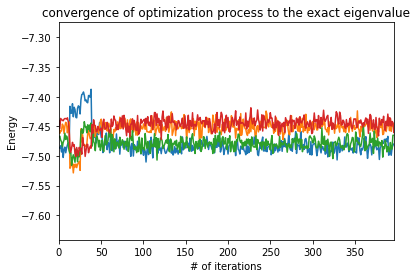

In [32]:
TI_approximated_energies = {'approximated_eneriges_0': [-7.48610307706854, -7.486723782889051, -7.482810231578335, -7.493273576407161, -7.479828480352569, -7.502450598250617, -7.4895475489140875, -7.485024426068045, -7.494529240753221, -7.486915714782895, -7.4812406211037, -7.478072287140875, -7.486696394899587, -7.416186448755935, -7.428041212203513, -7.4275734586457425, -7.41179815275807, -7.433825802958651, -7.417792354534976, -7.4216050984979915, -7.434787792179803, -7.43567064928438, -7.4194222964554335, -7.4153862256994225, -7.417358134838512, -7.429091207884353, -7.405295351807469, -7.396285793953423, -7.39558984034964, -7.392024840992557, -7.397681167239909, -7.406928770991795, -7.405246126381449, -7.409210646950148, -7.410278824585284, -7.398014105741087, -7.398230928971183, -7.401017429293576, -7.387443597679132, -7.472074683872723, -7.464192146730993, -7.455751997199061, -7.468359802462868, -7.466412009624977, -7.478069399443806, -7.457613160986113, -7.462403342953777, -7.463661590168495, -7.443841990603293, -7.455958358183351, -7.468723715906427, -7.468154752878167, -7.494308830335443, -7.485779492835288, -7.474133453655381, -7.481213530689586, -7.4613019582071605, -7.489291963111325, -7.477158360400578, -7.478742926233919, -7.494625546648124, -7.46206782050964, -7.472499702512299, -7.491304041698112, -7.473054951688384, -7.477197888312056, -7.474158117844414, -7.488216579127689, -7.462771384348415, -7.482984260805396, -7.478037977239373, -7.47302047840882, -7.4969181845922845, -7.477398145713258, -7.480175248220947, -7.475276063204357, -7.485903246335046, -7.47489961300012, -7.481688827691284, -7.484446883813385, -7.489885678170043, -7.4754390681553105, -7.483159901189514, -7.477113958841185, -7.48515789223563, -7.50058612916085, -7.478820407120378, -7.480148679046783, -7.500098813239903, -7.480880611159016, -7.482700417196134, -7.489848838566078, -7.491418068731401, -7.475069594800884, -7.484949686950907, -7.4810918399397766, -7.487986255011708, -7.496532216382229, -7.483252439109839, -7.4899134956905415, -7.498742736645968, -7.487164215879599, -7.492118325839262, -7.510145669085447, -7.492208530258451, -7.481137593181402, -7.497689849882493, -7.474556258933428, -7.494767413605475, -7.468325972497111, -7.484595546105312, -7.503291236240347, -7.471946470337287, -7.483315699312438, -7.484748743546803, -7.483045444948003, -7.488111452216684, -7.4953837726255745, -7.474657993176143, -7.490043997424133, -7.486511177426448, -7.49607722945638, -7.484661702570995, -7.483708100256069, -7.482924582400063, -7.4909188398890905, -7.495550079008459, -7.494550201846361, -7.489893510422797, -7.48634322598968, -7.481333003450981, -7.472949890082551, -7.476681415783412, -7.495138231201174, -7.482895466932934, -7.49832977701412, -7.494407725709813, -7.48410623975557, -7.494770369950861, -7.487300176338891, -7.490366609639089, -7.496814396882621, -7.4903697585789955, -7.48822450293137, -7.48684268883531, -7.496378310398552, -7.467826797681878, -7.489719377537677, -7.482032393280724, -7.483248806956987, -7.486606175028599, -7.475319729245496, -7.476842200779858, -7.4796593208572455, -7.4919429106143385, -7.469932614270471, -7.476314988069421, -7.491907255830472, -7.4822060736709615, -7.490101340235813, -7.485738779799602, -7.480642296785902, -7.47932284088958, -7.48474500788319, -7.488001134670265, -7.487178946245384, -7.474827316773932, -7.490349606811216, -7.4736755248538875, -7.4789078157039715, -7.481953532677826, -7.483390306357697, -7.475015210549731, -7.4836367799979975, -7.478040754489997, -7.466981862041912, -7.480126874132869, -7.48897008208771, -7.478006665225705, -7.481650383450338, -7.483361815066068, -7.488503676818399, -7.483325393975471, -7.4897954286183515, -7.494783298995742, -7.477872860447507, -7.485334959325589, -7.485452180859661, -7.470341335027474, -7.4837082056113875, -7.469692928708302, -7.493310805158731, -7.488465935098687, -7.475291791401475, -7.478074606864864, -7.497521419390355, -7.490156208532593, -7.484638857515614, -7.487196669604938, -7.485337864560863, -7.496682913173009, -7.483323319765799, -7.481254649695097, -7.477277452418906, -7.480961713396613, -7.480024137944327, -7.484213053845651, -7.490374573821759, -7.483647012119396, -7.499398933065004, -7.477057730734113, -7.472312697641175, -7.48856081437658, -7.490603336568917, -7.496642049765431, -7.483456819435653, -7.487347440911662, -7.488798712912177, -7.483949443932029, -7.491168099141369, -7.4922695069935115, -7.497851157685311, -7.477186889084071, -7.4955531411970755, -7.483770265496698, -7.494039835081234, -7.48712632792175, -7.474993553247055, -7.4800245899217535, -7.477712312908445, -7.4800880109468295, -7.467816030085094, -7.480226847894046, -7.481079920888275, -7.474479971317386, -7.497181621940377, -7.499344535940609, -7.4875817049083135, -7.48111023476945, -7.487521406168588, -7.474490914478255, -7.468055435938331, -7.4915071569556195, -7.490356050563339, -7.491869658055894, -7.479867266633178, -7.492741804200892, -7.485037104087558, -7.484304110496398, -7.481754243224183, -7.479258264172393, -7.497897783608492, -7.494052988527451, -7.485754349665832, -7.494421836944846, -7.479740851515555, -7.491016571251337, -7.48197669999348, -7.484593677882553, -7.493373591735571, -7.48624224128755, -7.49099005909679, -7.476947430045557, -7.473996377716406, -7.492133327380609, -7.475459058302177, -7.484391546574062, -7.47040544923227, -7.484796037907296, -7.479072426259655, -7.482993390778292, -7.476756200369366, -7.459749151167403, -7.485945937280437, -7.490131174605171, -7.484327944425561, -7.491999793764281, -7.476944414870557, -7.470281121333686, -7.475516049837756, -7.458790344698386, -7.495678475721423, -7.480247469386308, -7.482155351344415, -7.4823944561336555, -7.489122335409665, -7.458336266673032, -7.482030431520279, -7.488616228786611, -7.480807654170782, -7.488881449803893, -7.472119733874798, -7.470424480997156, -7.477370201661651, -7.494540961243827, -7.491895677352415, -7.48769526553559, -7.497643776677285, -7.47556762846311, -7.49837265609774, -7.482140974912831, -7.479886787907382, -7.478978575212035, -7.479681724498888, -7.485726787472311, -7.499559084918213, -7.4915417484787685, -7.480249207802323, -7.481118055580715, -7.488366588352006, -7.494775914543214, -7.485193834859006, -7.4838158105243116, -7.4900280641560455, -7.487300580715327, -7.496990253942395, -7.495002755918185, -7.473592933014259, -7.501580179104633, -7.487855183950995, -7.500153283201556, -7.491781508494551, -7.492673538366444, -7.483937515069359, -7.476570781711123, -7.495666546418539, -7.492947167410758, -7.480529502942846, -7.480494303962087, -7.506646254873738, -7.4838764844885866, -7.478397790693095, -7.494074245789144, -7.485845796732796, -7.483584152114549, -7.491325552415877, -7.4825651930159145, -7.488677188664303, -7.467908787628164, -7.484602833523505, -7.484866091689507, -7.478172845669615, -7.48159653782238, -7.492836783384295, -7.48553255081869, -7.489391663986729, -7.489896349730503, -7.486408269656438, -7.495053595258155, -7.479788207190984, -7.493004392933212, -7.492857825890961, -7.494922189758845, -7.468603147332658, -7.4808972706929335, -7.469512893166015, -7.490874882617477, -7.49795319144211, -7.487071338244909, -7.489694057251273, -7.485040831050696, -7.469596511381305, -7.475209839429052, -7.467388699851269, -7.484770481386114, -7.504048946505809, -7.490860674228631, -7.481349806445602, -7.4797532329672825, -7.48345953138694, -7.498146252043135, -7.484310684525517, -7.489521736209284, -7.484914858221437, -7.476917206121452, -7.484041859979084, -7.489440717349582, -7.487549601462495, -7.485462759045165, -7.505852909408728, -7.485808313339135, -7.483740076311552, -7.475405422997955, -7.479023257483503, -7.478129542804804, -7.471933492413525, -7.475129133875737, -7.471041135568462, -7.475920181998975, -7.466877151423304, -7.498718984510194, -7.49715575778027, -7.488880711770243, -7.498802515625715, -7.486461697812446, -7.482079522703727, -7.479968312517572], 'approximated_eneriges_1': [-7.4506071773052245, -7.461731073615225, -7.457753794030608, -7.457766999211942, -7.44619891388073, -7.448763794388806, -7.4620895000942005, -7.450026382269584, -7.443199277053309, -7.445386248595789, -7.460793852672715, -7.450550748574033, -7.442439198548255, -7.5207043436289895, -7.518000630340059, -7.509331204967379, -7.5124050449460436, -7.528497664975473, -7.513950604309557, -7.5188287305036825, -7.5135536450062705, -7.519606620745729, -7.513745511983021, -7.512056997710877, -7.50934052217067, -7.524254897919779, -7.454248655061347, -7.476088123633435, -7.464151632106609, -7.479417193202009, -7.480839340469205, -7.482020721885548, -7.484337742387407, -7.479546705411845, -7.46257123386425, -7.456258037870158, -7.465142399408997, -7.470827523590994, -7.470076121434965, -7.468826275134333, -7.447738330674512, -7.450396610966431, -7.450054890927967, -7.467712831358273, -7.458143107264338, -7.459789654501258, -7.451360925303108, -7.46232963162814, -7.449539209596426, -7.44124501074082, -7.43790012128875, -7.464436063186806, -7.4487207659533246, -7.450545957243202, -7.455025000767458, -7.443582112080499, -7.445695066635967, -7.458043071209333, -7.450376430378094, -7.444692359414171, -7.450997184467367, -7.449339624694086, -7.463452568945933, -7.4678067185298485, -7.469338188317582, -7.455218192491976, -7.458966482152807, -7.452046671514501, -7.45610773691302, -7.4423926650515435, -7.453105971152402, -7.454168355196282, -7.4345467290599325, -7.4538902175327335, -7.452116583920351, -7.450102824370702, -7.452952720723066, -7.450672310984285, -7.436507554826626, -7.4483506412491876, -7.456764273705156, -7.438975332706105, -7.458364605124199, -7.451713134315159, -7.439373599284182, -7.437428142937276, -7.4558069881546585, -7.446088649406809, -7.459522770189139, -7.453913166276524, -7.44596505976141, -7.464884611462967, -7.442561017853528, -7.465028549093118, -7.443719651674431, -7.450705492165227, -7.458161006802158, -7.449055985740757, -7.453553915683858, -7.4544437799902985, -7.445914555879877, -7.450830012565952, -7.455100239384865, -7.437066773380174, -7.459023091388312, -7.458986069211907, -7.459815917806207, -7.4602120300504415, -7.457525169382408, -7.460313418954324, -7.432110756094252, -7.455792674294436, -7.450720823371195, -7.439706669566937, -7.465064964891913, -7.456610625371886, -7.452178096907796, -7.446749495572982, -7.4566177724577445, -7.460406922615384, -7.4478810532616055, -7.453677824431705, -7.447280835437864, -7.457073522349793, -7.453661585124276, -7.449974372753268, -7.458304617712803, -7.435360318868284, -7.443418180602542, -7.452100986748681, -7.459897844464231, -7.451599292650484, -7.437027402788287, -7.425615054925129, -7.465133646034896, -7.459419470643782, -7.452959933866748, -7.440513361329145, -7.4656234617943245, -7.442123581520162, -7.452723383409597, -7.4540938483556065, -7.45095411607733, -7.44608821091538, -7.449251910232674, -7.4540202161269855, -7.449854398999977, -7.453588357391839, -7.430168245144552, -7.444690134523648, -7.44700104485719, -7.470694660932059, -7.452647342552117, -7.45179104858867, -7.460512942236891, -7.4507650914281225, -7.454357590527905, -7.441544830021885, -7.4403208961011496, -7.437205314246334, -7.465794895920977, -7.4412138536889305, -7.455327942566603, -7.449400896760411, -7.44195348942601, -7.443154618120945, -7.473335598675789, -7.441110454881379, -7.469604959237843, -7.4685912937388474, -7.440232986935778, -7.449404309329802, -7.447392685515767, -7.452224293159242, -7.440645902094572, -7.44693506917251, -7.435974232337056, -7.460415338899706, -7.44609818254488, -7.4529762938154684, -7.462366822798069, -7.462464963892662, -7.430966418774701, -7.43981457294221, -7.445570020748801, -7.45260016651313, -7.429555547291851, -7.459910927023882, -7.453193201918741, -7.451636564552512, -7.455684592426713, -7.459535169717674, -7.463997216763511, -7.446786207353208, -7.445827796070802, -7.456886320390038, -7.437893237832267, -7.457346838850337, -7.453687694317711, -7.451296566209844, -7.448646102577246, -7.458295510545449, -7.441496716562562, -7.449775566747532, -7.432012889748637, -7.442872608943358, -7.451480454744692, -7.448715472038054, -7.451295044729608, -7.4697962617392895, -7.453290231819462, -7.456074420289085, -7.455734498739439, -7.43851144329802, -7.465603209353795, -7.428433365379727, -7.464923822568625, -7.455127234274573, -7.437780300341456, -7.449014057923204, -7.453273784149686, -7.455085895282263, -7.461809786402237, -7.465395656540972, -7.455561090448254, -7.461345402111719, -7.4353790436754, -7.459082486684899, -7.436102200755068, -7.45252592014432, -7.454758689755, -7.44351573722002, -7.466546152930857, -7.467702461315257, -7.450922242524136, -7.448862792147863, -7.45929002238518, -7.449017332227877, -7.4414287033986435, -7.446798180772227, -7.45197792102243, -7.452166547494119, -7.451298254326555, -7.452216630240136, -7.4515100050052565, -7.4242031186986885, -7.4296892513093935, -7.447761555312589, -7.450956146997319, -7.440074760783942, -7.442945030511763, -7.450457409633883, -7.451785924921297, -7.4432905977460395, -7.4616220240741615, -7.455263723744185, -7.458598062291323, -7.43569464383777, -7.442942057320321, -7.464277813559641, -7.4444339687161465, -7.449587078033655, -7.462814344757779, -7.448769772182369, -7.446279143661101, -7.472367374285511, -7.4613840827203814, -7.4625222075400535, -7.446390632244204, -7.448584961541867, -7.439885489868853, -7.454523396529107, -7.462952290232783, -7.4642889136874615, -7.43822795570424, -7.432029028581613, -7.45897391125852, -7.458480420377186, -7.44828789899458, -7.452359456678415, -7.44457839999951, -7.445286160672384, -7.45481298298211, -7.458251927523483, -7.4355311157180735, -7.459324787653983, -7.444444595948499, -7.451463005119671, -7.436430187994206, -7.459666481600844, -7.450809963286693, -7.457191535997887, -7.429612020227978, -7.4484552924141925, -7.461224427845319, -7.45146302249915, -7.456643902984, -7.439725765699915, -7.454481124209491, -7.4458005475673055, -7.442066169043126, -7.452234825717385, -7.455619009391559, -7.444312797389063, -7.446201027595479, -7.456153986204841, -7.455853043922656, -7.44027010456794, -7.44026690408757, -7.444964135796234, -7.436830257771675, -7.450734961394324, -7.447645225309801, -7.447198525079831, -7.436951460445753, -7.454503811968594, -7.455335579294359, -7.459361662356097, -7.452234218321372, -7.464466093484495, -7.449447519727202, -7.441611191579872, -7.4474670714466695, -7.4513840531585345, -7.446211728296765, -7.446740287686295, -7.461637185572511, -7.446614414054482, -7.453746573668241, -7.451701120712225, -7.44393496674275, -7.451560210524743, -7.459836078032598, -7.440995036526177, -7.446864097550485, -7.452430061327229, -7.449990325283152, -7.4589852892987665, -7.447333726656047, -7.4604154659474995, -7.4510252775779025, -7.44738015816038, -7.447558841456054, -7.459852667970245, -7.450032655134031, -7.434853801690793, -7.450274337318491, -7.458293920593813, -7.450184489602379, -7.4482449532363, -7.4552818472627225, -7.452770606738545, -7.452523878953269, -7.423906887487022, -7.453046094827937, -7.4561093765743705, -7.467621847457991, -7.450083758173229, -7.453146989941051, -7.459928311525997, -7.448552386645248, -7.4505035271159, -7.449441477583026, -7.446571917285241, -7.443054529008354, -7.44771195433254, -7.451025742785079, -7.440917764602051, -7.456514100863255, -7.439578057527274, -7.449670676484598, -7.457916289373851, -7.446261658303877, -7.446867265196236, -7.460918274265313, -7.456029616545258, -7.468975405275325, -7.4510950833695535, -7.459823640525059, -7.439027088099632, -7.441769857036652, -7.452234938560653, -7.444203460391627, -7.463952088758346, -7.462843871553728, -7.449228845096301, -7.450245890098431, -7.458804788297503, -7.450262705500495, -7.433386518063636, -7.442034910448613, -7.457271884883772, -7.4368435251763225, -7.458265927964961, -7.443472077286886, -7.449324310426146, -7.445802977521722], 'approximated_eneriges_2': [-7.468443770407524, -7.466645510661784, -7.4729808221874645, -7.47600212464808, -7.484103954704659, -7.47702248921851, -7.473190645631638, -7.461506766267785, -7.472146185783253, -7.466293485577934, -7.4698615494431575, -7.481981001433543, -7.491094175732574, -7.495339817164957, -7.494074701296847, -7.51573281879162, -7.503443760360534, -7.497976260055719, -7.504535670800607, -7.510550017749336, -7.488251659381121, -7.4953390993984605, -7.509827183103446, -7.49450911352517, -7.501350397748671, -7.489991658017154, -7.458228142767173, -7.453991420356151, -7.461980442371011, -7.4585341963201275, -7.442105833732952, -7.450630379322763, -7.45049241098066, -7.460749162023956, -7.4474381059242205, -7.455288317333743, -7.447767539777291, -7.458930512567481, -7.444287838294166, -7.4834640803532455, -7.459176589041756, -7.475730693647938, -7.478905554093111, -7.491005889025542, -7.471463875728642, -7.466075284942036, -7.473067578741364, -7.484663750690954, -7.47358141360114, -7.490524261722021, -7.482751568295009, -7.4733779864699645, -7.488864727220798, -7.492456969815532, -7.473936619826159, -7.465226893155126, -7.481219886277993, -7.478288693900329, -7.473807624203349, -7.457743062502701, -7.467954067773503, -7.454016732234277, -7.490323424417159, -7.463944395020018, -7.470742839963937, -7.492878066199759, -7.4710835210524875, -7.487291967785557, -7.479748797237624, -7.476403447123556, -7.481137219144072, -7.486646698192399, -7.46838479786497, -7.4824423863185805, -7.479827674478911, -7.472580994548254, -7.47591205083395, -7.48857638120188, -7.477784573869883, -7.475347454622755, -7.483178605180124, -7.470013724180773, -7.492293596994434, -7.4810611814384425, -7.464258729478069, -7.468654295635174, -7.473977970822335, -7.457331525050654, -7.48034828235476, -7.488938934135284, -7.48486398670196, -7.4847822789923155, -7.4943239289210615, -7.483482960812705, -7.492524245024556, -7.4682888501422795, -7.484899339743667, -7.495760656377221, -7.469670017793545, -7.487457475100175, -7.4858881155302255, -7.490027280662763, -7.462052556005528, -7.478373648539279, -7.486893470697356, -7.475588731560746, -7.477983293545904, -7.493204078050926, -7.495555335370091, -7.474226929867125, -7.484094647090769, -7.480549824713649, -7.484459092565291, -7.462323338798403, -7.484092047940245, -7.468996804063233, -7.506861758448192, -7.470390745619391, -7.486388741377882, -7.483924703190368, -7.469648018120406, -7.4703547601307845, -7.474306515122034, -7.487211583888868, -7.483432533652689, -7.480341064928347, -7.476106329382182, -7.473013931936159, -7.478558545953398, -7.4636402291563035, -7.49129307094832, -7.492749855214597, -7.471307238722772, -7.476078972213423, -7.490100844897442, -7.478739502933006, -7.47999051836295, -7.475151554314991, -7.481824443138437, -7.473466050889719, -7.488310039822433, -7.482917037501743, -7.476979967463481, -7.494029944208075, -7.4668725736909325, -7.476982435946077, -7.469904088219638, -7.476458186142431, -7.488257265330328, -7.477841065944376, -7.4812947439350515, -7.467754715482038, -7.485899707042398, -7.48328851892811, -7.48742519514494, -7.491739652480756, -7.478517480191834, -7.468394839196495, -7.462489843378108, -7.476391488432708, -7.481288073341007, -7.495767894904575, -7.475624146794046, -7.478841135231067, -7.488029423137055, -7.474502407124445, -7.483605164991362, -7.4713866059063365, -7.492387668054196, -7.488658184588048, -7.479826645878488, -7.467389564178605, -7.468599302975481, -7.487368474118183, -7.472658566326444, -7.478332520676398, -7.4848836700829375, -7.478178300055331, -7.476121684299434, -7.479952927551217, -7.4769653078212865, -7.481382878441106, -7.495782021487047, -7.47068522227945, -7.493402324573409, -7.46498493016321, -7.481192610351661, -7.474711864554412, -7.4655789140501145, -7.4760533407930705, -7.459433697527903, -7.4852516551467065, -7.482725153829039, -7.469790113662764, -7.4674377293904755, -7.480150809734262, -7.478662890076073, -7.469123510237879, -7.485809269973422, -7.489221429952263, -7.470631398624586, -7.477895487538983, -7.465772866598086, -7.492752701137841, -7.481353088636302, -7.475149940754739, -7.486218290131084, -7.492829750930009, -7.475292619953555, -7.4916611721814625, -7.472512029510369, -7.475002333766593, -7.462931339164145, -7.463908968056722, -7.4741743508070755, -7.477521971109058, -7.473413764109806, -7.486756590845348, -7.477163518956591, -7.483002281738439, -7.4752474961964355, -7.4825567702581, -7.471464078737239, -7.478546479874815, -7.471262397481268, -7.481430263929043, -7.472178193639098, -7.492083989571954, -7.467773308906224, -7.4811241636112795, -7.484669556967623, -7.484174210163405, -7.485301954009019, -7.465820506781876, -7.489123618069975, -7.472168318043661, -7.477772425929949, -7.478006750987593, -7.482626736108681, -7.476614742727483, -7.489710462791816, -7.4759081721881735, -7.481090183701025, -7.476520707959966, -7.488415034940452, -7.47127444888591, -7.482773945236346, -7.474784945128061, -7.480462272456409, -7.4805749779803525, -7.489911640903951, -7.47391629079683, -7.465559973620009, -7.495661808481737, -7.4804629508331875, -7.481061158088883, -7.483718523877363, -7.479520130563795, -7.482415822705728, -7.4870671167874665, -7.48547395731856, -7.466741876516648, -7.485112332728944, -7.477555683587615, -7.479527259527469, -7.481346801751576, -7.4772296111796175, -7.472625861956685, -7.481883945242537, -7.480132973163321, -7.493568963043072, -7.482249877781296, -7.4791077690276095, -7.485672650889935, -7.481335521102796, -7.485933777637585, -7.4707932773512615, -7.477216252945061, -7.47548903138874, -7.470163896243819, -7.488588832369217, -7.462055945441943, -7.471070171110763, -7.4788715341906125, -7.471276348192256, -7.471636382900911, -7.486208634409254, -7.4720168633741695, -7.492716786118252, -7.485756667967315, -7.4842954129931805, -7.483450824015229, -7.486907614725537, -7.482567883681717, -7.487477186553357, -7.4861588862265265, -7.467928277991069, -7.465954141574651, -7.469450447538506, -7.4701318623736634, -7.47780789965603, -7.476911364342399, -7.4661602935974445, -7.470639070378843, -7.483885500060726, -7.486675840825788, -7.485812217427426, -7.474975753639987, -7.48015790718113, -7.4823267743202955, -7.486354330802545, -7.452450648208124, -7.47960236493077, -7.480316859115045, -7.466448978934856, -7.491603528643155, -7.474461250075182, -7.480527629436221, -7.47163591260127, -7.481189797945427, -7.5007236605956775, -7.477592352336086, -7.476394973805229, -7.489292240806733, -7.504387137180701, -7.4786971276613174, -7.476986057860267, -7.475530769799518, -7.482540610001967, -7.48051734280592, -7.473401884637221, -7.468324492816274, -7.472710570453243, -7.484714173400744, -7.486117399493693, -7.48204122506332, -7.487196472843378, -7.489715836944093, -7.482284678003849, -7.4843196983577975, -7.466832726657984, -7.462206243234003, -7.464332663221765, -7.490185284027913, -7.487946325364149, -7.479423908172911, -7.475588643070512, -7.468682082206767, -7.469404184812634, -7.493324608837322, -7.488604856061079, -7.459446057683842, -7.474881652165369, -7.473586845046486, -7.478605016597276, -7.477206333651576, -7.483150407474931, -7.483590231981262, -7.476891639797856, -7.465346142522106, -7.448324705010751, -7.4682224081478115, -7.491169140929844, -7.475665087503638, -7.488467393957651, -7.485341279382499, -7.482147380249552, -7.4805190054236395, -7.4611868097026415, -7.477216506151441, -7.472990805479332, -7.470153461742064, -7.495686525329384, -7.457818091200431, -7.483063871122298, -7.474646724920758, -7.482650494743256, -7.469891241451863, -7.484519768918915, -7.476243449203905, -7.478086582978633, -7.482086547348204, -7.473998612142949, -7.501926856604583, -7.48431129986244, -7.487683169847782, -7.47395426395781, -7.480810982875687, -7.493147912221463, -7.483905021637191, -7.487584544655544, -7.492752843787346, -7.477259272000664, -7.48815495790301, -7.488216911749845, -7.46508289413327, -7.4650325992217565], 'approximated_eneriges_3': [-7.440501110513324, -7.454116142570479, -7.436688111157893, -7.438406995911601, -7.43989314656158, -7.440553029021839, -7.437957316494138, -7.4367508013570065, -7.436926197217274, -7.437794482082255, -7.435606145559833, -7.441771750740096, -7.453291756782892, -7.483697504290974, -7.4938682668133145, -7.486011053538427, -7.476975590194694, -7.4830151760001264, -7.480865121788435, -7.496163827201113, -7.5008477942612215, -7.485624954554724, -7.49272049208065, -7.49943946922065, -7.485442144016719, -7.4906691402820025, -7.486949231199139, -7.496998736122835, -7.4688960670408475, -7.481743230644548, -7.481685344408113, -7.500709858456248, -7.49011326940913, -7.480479434480402, -7.480351450034156, -7.494423876244561, -7.487768505445791, -7.483536397694418, -7.486876560486835, -7.447354144563468, -7.461657486613689, -7.438960081617904, -7.448035187086213, -7.448736774301431, -7.4588708459281845, -7.4586481625943994, -7.450160247372326, -7.453192152071426, -7.456813825663889, -7.45678788763334, -7.453015744699898, -7.468474521792151, -7.44326128109269, -7.437985091474462, -7.451973729384804, -7.454713853832181, -7.4527743342230774, -7.443200283570279, -7.44862601438123, -7.457583859138497, -7.460828885789569, -7.455142309190267, -7.437762579583242, -7.450189406924475, -7.447475691869131, -7.43247318542584, -7.438672223619925, -7.439833684846898, -7.455306885992285, -7.447584944458738, -7.455471060595555, -7.444644623733445, -7.440461512845975, -7.435852066451018, -7.450556639047925, -7.432284572396466, -7.454375942176464, -7.431372460326893, -7.441637211120857, -7.453468877666254, -7.465768469643748, -7.444361019472597, -7.4597049902972055, -7.449600349932769, -7.46776782171982, -7.445993525112716, -7.4457037092029505, -7.4373428718337795, -7.456108057640568, -7.440017328281446, -7.44700963202963, -7.456452865517984, -7.456662838467976, -7.43168668115306, -7.4634336491484, -7.461781591089746, -7.451019047388963, -7.438017196245007, -7.444352631104966, -7.441132155791573, -7.440285494333449, -7.438049210380839, -7.449251325825179, -7.436365692985626, -7.444530636398076, -7.433636986116937, -7.447993173841828, -7.443158719939124, -7.449736155473, -7.431859561367895, -7.442829739865237, -7.45543764435226, -7.442497972798646, -7.426701386483503, -7.426798905565251, -7.448896694987686, -7.428913734288547, -7.444411346538309, -7.43656436076003, -7.448369292350482, -7.440260342288243, -7.472250125161803, -7.434340657647005, -7.424082443323114, -7.441359554537234, -7.439303902712369, -7.447490058074378, -7.455687852298232, -7.433314920914563, -7.452482712210739, -7.432527400489077, -7.443333027868942, -7.4440596383791435, -7.443174302944044, -7.4286045865865145, -7.443299152846675, -7.441648855965155, -7.447572838390079, -7.444747091933483, -7.455771193124515, -7.450309537111107, -7.440292325012237, -7.441074846702872, -7.44927640020169, -7.449865546287582, -7.443550466261892, -7.436141730940682, -7.45245233722991, -7.453235983377405, -7.432073365742726, -7.451381018569343, -7.454411437238874, -7.446222660455876, -7.431282992370313, -7.455944094678408, -7.440099553448864, -7.448448221062958, -7.4500343971789045, -7.426991817702066, -7.454562168907103, -7.44694679885394, -7.447112831589604, -7.449912446217016, -7.442335211620941, -7.4305209774001, -7.4398019432880735, -7.439064812626386, -7.434996376422183, -7.443180638882372, -7.445770230863988, -7.440746755327773, -7.4407344303119825, -7.440221021610772, -7.4509304901338504, -7.434534172955247, -7.446145949728326, -7.4412931866764, -7.4520342938814075, -7.436886419093183, -7.444499528302439, -7.455399555795612, -7.462027326581648, -7.459676275212278, -7.456860515130582, -7.445930320722018, -7.46154365411176, -7.440743252068424, -7.426651826418165, -7.449039922846983, -7.438716965075259, -7.452115205734466, -7.436873106961097, -7.426297306612024, -7.430808836192277, -7.457895082420599, -7.443374712112873, -7.460764149097643, -7.438713540803078, -7.43120598822942, -7.451585077523432, -7.434994431531465, -7.455091853755172, -7.459703835609949, -7.4528219048481485, -7.445876940715111, -7.43496797577502, -7.439924361584705, -7.448738983659313, -7.437722661342776, -7.4238196772321166, -7.448304773107822, -7.44089345025828, -7.441710226103643, -7.456205884455883, -7.434106563858555, -7.445177296671183, -7.443928329874395, -7.443507852147474, -7.445329613263398, -7.448131789363435, -7.449307721281088, -7.427332732177483, -7.454460524104377, -7.441228197774866, -7.450673688320897, -7.44057249764104, -7.434456237951973, -7.418707192497371, -7.439486332643646, -7.446008278936553, -7.442063149854261, -7.435790909837632, -7.448909241531701, -7.4425095859226715, -7.439545707234742, -7.4223241180690325, -7.438275126847994, -7.4451919925156504, -7.456343451813517, -7.449996758999473, -7.430523427733014, -7.457916379475346, -7.431320498394812, -7.435935997391662, -7.441462436627007, -7.453928253051181, -7.44380968919477, -7.438279527322965, -7.443493195027764, -7.439545810208663, -7.426952837493478, -7.436469375575394, -7.4359144653939255, -7.452912455586231, -7.4468001984344365, -7.456352894134669, -7.432741109051519, -7.452309974149265, -7.444384623885309, -7.440550676687375, -7.465651692706707, -7.442641286292979, -7.459261197103682, -7.450074659680927, -7.444793730291911, -7.450306180418338, -7.443203047932958, -7.460449883530102, -7.435353694943647, -7.4401810534063015, -7.444541963315337, -7.448405893838893, -7.441013144795424, -7.444106062970419, -7.431686910000772, -7.458848592895657, -7.439199279512848, -7.44169042076105, -7.439856947612138, -7.453640457682652, -7.447367198668068, -7.435827050769194, -7.444076481252777, -7.437911537779106, -7.4479625777793315, -7.4337615796393175, -7.443278068114253, -7.444445307161506, -7.440059594363034, -7.437960977585828, -7.430715586981338, -7.449775462982477, -7.453180313672491, -7.445331424644856, -7.442363808189289, -7.447779333614414, -7.450509925401051, -7.4406391726220775, -7.443563559709869, -7.4621002214464385, -7.460461539336029, -7.442945754790846, -7.427411525822722, -7.442608211753693, -7.43967248752784, -7.438500561249945, -7.452944068045566, -7.431745680137082, -7.444451189641335, -7.453241812607849, -7.434996716741632, -7.447014671760399, -7.439727592129015, -7.422765952162812, -7.439011588063697, -7.4414692347507865, -7.437881688136411, -7.433247081216122, -7.431453420361028, -7.450391975156341, -7.449631847534271, -7.447791337255879, -7.434893420479973, -7.455119886557738, -7.444240825341415, -7.452243435948635, -7.4546427985331025, -7.44046072765857, -7.4253221841133294, -7.428090090641243, -7.441826091390246, -7.446174705560538, -7.4259825811779985, -7.431559925996282, -7.447829047859066, -7.446982074777158, -7.439473709881985, -7.4415137129184545, -7.450559220006276, -7.4535744984656285, -7.438581503296536, -7.450659141658013, -7.445025846269835, -7.448224932464525, -7.436992615064226, -7.441404553871801, -7.4514029056531434, -7.454083490347186, -7.445002506558709, -7.437162786087321, -7.437914939414278, -7.437376742113357, -7.451698531941096, -7.451399661506675, -7.442429442888085, -7.440470368721425, -7.444873665560551, -7.439162702239539, -7.444553318959843, -7.451554088140986, -7.444000747612743, -7.447918298429055, -7.440172212450286, -7.435721708485265, -7.44462171694232, -7.437809936365564, -7.461869583365945, -7.442233823473729, -7.429933738096434, -7.43238033766886, -7.453728178077005, -7.4500541495762596, -7.439004859029238, -7.454974965704287, -7.454802540632588, -7.435059754958671, -7.452308090540091, -7.454744289247169, -7.46608992534616, -7.436242297003731, -7.445947760652886, -7.4481106420557746, -7.4384548138157935, -7.4433143493580785, -7.432953518668621, -7.451494758418083, -7.457011976979956, -7.441367510022224, -7.44874991468168, -7.429318196652876, -7.449308563282159, -7.4354849137570085, -7.436351858085384, -7.4494768631607675, -7.441799672962524, -7.4433185270573565, -7.460235497451034]}
plot_convergence_of_optimization_process(TI_approximated_energies, 0.8)

In [ ]:
## initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=12)
optimizer_result = minimize(cost_function,x0=initial_thetas,args=(LiH_molecule_4_qubits),method="BFGS",options={"maxiter":NUM_ITERATIONS})
print(optimizer_result)
optimal_thetas = prepare_circuit_params(optimizer_result.x)

computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
optimal_ansatz_state = get_ansatz_state(optimal_thetas, computational_eigenvectors[K-1])
pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_string(LiH_molecule_4_qubits)


In [114]:
print(get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings))
print(optimal_thetas)

-7.57072049639962
{'thetas': array([0.74760824, 0.17289584, 1.48511553, 2.87050967, 1.1083423 ,
       3.83152585, 4.61583078, 3.2915738 ]), 'phis': array([4.29275154, 5.47569434, 2.44077279, 1.02772525]), 'D1': 2, 'D2': 8}


In [115]:
pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_string(LiH_molecule_4_qubits)
computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
for eigenvalue_index, eigenvector in enumerate(computational_eigenvectors):
    print(eigenvector)
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, eigenvector)
    print("eigenvalue for k =", eigenvalue_index)
    print(get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
eigenvalue for k = 0
-7.162165959477899
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
eigenvalue for k = 1
-7.517719632622515
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
eigenvalue for k = 2
-7.589285715860265
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
eigenvalue for k = 3
-7.563737559574652


In [120]:
from numpy import linalg as LA
eigen_values = LA.eig(LiH_molecule_4_qubits.to_matrix())[0]
print(sorted(eigen_values, reverse=True))

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
